In [ ]:
from collections import OrderedDict
from google.colab import drive
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 4]
matplotlib.rcParams['font.size'] = 10
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [ ]:
!pip install pylogit

**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [ ]:
file_path = '/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py'
with open(file_path, 'r') as file:
    lines = file.readlines()

lines[14] = 'from collections.abc import Iterable\n'

with open(file_path, 'w') as file:
    file.writelines(lines)

In [ ]:
import pylogit as pl

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CMAP Dataset

## Data import

In [ ]:
size = 10000
path = '/content/drive/My Drive'
data1 = pd.read_pickle(f'{path}/CMAP/london_processed_raw.pkl')

# Restore the original dataset
col = ['age', 'male', 'driving_license', 'car_ownership', 'pt_n_interchanges', 'dur_walking', 'dur_cycling', 'dur_pt_access', 'dur_pt_inv',
       'dur_pt_int_total', 'dur_driving', 'cost_transit', 'cost_driving_total']
train_df = pd.DataFrame(data1['X_train'], columns=col)
train_df['mode'] = data1['Y_train']
test_df = pd.DataFrame(data1['X_test'], columns=col)
test_df['mode'] = data1['Y_test']
data1 = pd.concat([train_df, test_df])
data1['dur_pt_total'] = data1['dur_pt_access'] + data1['dur_pt_inv'] + data1['dur_pt_int_total']
data1['dur_active'] = (data1['dur_walking'] + data1['dur_cycling']) / 2
data1['mode'] = data1['mode'].replace(0, 2).replace(3, 0)

data1['young'] = (data1['age'] < 25).astype(int)
data1['old'] = (data1['age'] > 55).astype(int)
data1['hhveh_1'] = (data1['car_ownership'] == 1).astype(int)

data1 = data1[['young', 'old', 'male', 'driving_license', 'car_ownership', 'hhveh_1', 'pt_n_interchanges', 'dur_driving', 'cost_driving_total',
               'dur_pt_total', 'cost_transit', 'dur_active', 'mode']].sample(size, random_state=6)
data1 = data1.rename(columns={'driving_license': 'license', 'car_ownership': 'hhveh', 'pt_n_interchanges': 'transfer', 'dur_driving': 'auto_time',
                              'dur_pt_total': 'transit_time', 'dur_active': 'active_time', 'cost_driving_total': 'auto_cost',
                              'cost_transit': 'transit_cost'})

var, alt = 'transit_cost', 1

In [ ]:
data = pd.DataFrame(StandardScaler().fit_transform(data1), columns=data1.columns, index=data1.index)
data['mode'] = data1['mode']

In [ ]:
train_size = int(size*.7)
val_size = int(size*.1)
test_size = size - train_size - val_size

data_test = data.nlargest(test_size, var)
data_remain = data.drop(data_test.index)
data_train = data_remain.sample(train_size, random_state=6)
data_val = data_remain.drop(data_train.index)

## Data processing
2. Build a dataframe with average values, except for the visualized variable,
3. Develop a function to build dataframes for model regularity calculation, and
4. Load the data for training, validation, and testing.

In [ ]:
upper, lower = data[var].max(), data[var].min()
prb_size = 201
data_prb = pd.DataFrame(np.zeros((prb_size, len(data.columns))), columns=data.columns)
data_prb[var] = np.linspace(lower, upper, prb_size)

In [ ]:
num_var = data.columns.get_loc(var)

def gen_reg_df(data, upper, lower):
    'Function to build a dataset for regularity calculation'
    data_reg = data.copy()
    data_reg = data_reg.loc[data_reg.index.repeat(2)]
    data_reg.iloc[np.arange(1, len(data_reg), 2), num_var] += (upper - lower) / 200
    return data_reg

In [ ]:
class Load(Dataset):
    'Class to load the datasets for modeling'
    def __init__(self, data):
        x_set = data.drop(columns='mode')
        y_set = data['mode']
        self.X = Variable(torch.tensor(x_set.values).float(), requires_grad=True)
        self.y = torch.tensor(y_set.values)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

train_loader = DataLoader(Load(data_train), batch_size=train_size//10, worker_init_fn=seed_worker, generator=g)
val_loader = DataLoader(Load(data_val), batch_size=val_size, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(Load(data_test), batch_size=test_size, worker_init_fn=seed_worker, generator=g)

# Datasets for model analysis
prb_loader = DataLoader(Load(data_prb), batch_size=prb_size, worker_init_fn=seed_worker, generator=g)
train_reg_loader = DataLoader(Load(gen_reg_df(data_train, upper, lower)), batch_size=2*train_size, worker_init_fn=seed_worker, generator=g)
val_reg_loader = DataLoader(Load(gen_reg_df(data_val, upper, lower)), batch_size=2*val_size, worker_init_fn=seed_worker, generator=g)
test_reg_loader = DataLoader(Load(gen_reg_df(data_test, upper, lower)), batch_size=2*test_size, worker_init_fn=seed_worker, generator=g)

## True market shares

In [ ]:
l_alt = ['Auto', 'Transit', 'Active']

def true_share(df):
    'Function to calculate the true market shares'
    y = df['mode'].replace(0, l_alt[0]).replace(1, l_alt[1]).replace(2, l_alt[2])
    return y.value_counts(normalize=True).round(3)[l_alt]

In [ ]:
# Training set
true_share(data_train)

mode
Auto       0.438
Transit    0.313
Active     0.249
Name: proportion, dtype: float64

In [ ]:
# Validation set
true_share(data_val)

mode
Auto       0.445
Transit    0.315
Active     0.240
Name: proportion, dtype: float64

In [ ]:
# Test set
true_share(data_test)

mode
Auto       0.473
Transit    0.484
Active     0.043
Name: proportion, dtype: float64

# Random utility models (RUMs)
The RUMs are estimated based on unstandardized inputs and a data frame with wide format.

In [ ]:
def convert(df):
    'Function for data format conversion'
    df = df.reset_index(names='obs_id', drop=True)
    for a in ['auto', 'transit', 'active']:
        df[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = df.columns.tolist()[:7]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'transit_time'), (2, 'active_time')]),
                u'cost': dict([(0, 'auto_cost'), (1, 'transit_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_transit', 2: 'ava_active'}
    # Observation ID column
    df['obs_id'] = np.arange(df.shape[0], dtype=int) + 1
    # Wide format -> long format
    df_lg = pl.convert_wide_to_long(df, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode', 'alt_id')
    return df_lg

In [ ]:
data1_test = data1.nlargest(test_size, var)
data1_remain = data1.drop(data1_test.index)
data1_train = data1_remain.sample(train_size, random_state=6)
data1_val = data1_remain.drop(data1_train.index)

In [ ]:
data1_train_lg = convert(data1_train)
data1_train_lg

obs_id  alt_id  mode  young  old  male  license  hhveh  hhveh_1  \
0           1       0     1      0    1     0        0      1        1   
1           1       1     0      0    1     0        0      1        1   
2           1       2     0      0    1     0        0      1        1   
3           2       0     0      0    0     0        1      1        1   
4           2       1     1      0    0     0        1      1        1   
...       ...     ...   ...    ...  ...   ...      ...    ...      ...   
20995    6999       1     1      0    0     1        0      0        0   
20996    6999       2     0      0    0     1        0      0        0   
20997    7000       0     0      0    0     0        1      1        1   
20998    7000       1     0      0    0     0        1      1        1   
20999    7000       2     1      0    0     0        1      1        1   

       transfer      time   cost  
0             0  0.093889   0.25  
1             0  0.156944   1.50  
2             0  0.197222   0.00  
3             0  0.377500  11.45  
4             0  0.595278   0.00  
...         ...       ...    ...  
20995         2  0.922500   1.85  
20996         2  2.917639   0.00  
20997         0  0.109444   0.25  
20998         0  0.162222   2.40  
20999         0  0.189306   0.00  

[21000 rows x 12 columns]

## Multinomial logit (MNL)
Auto is set as the reference alternative for sociodemographics.

In [ ]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2]
name['intercept'] = ['asc_transit', 'asc_active']

# Individual-specific variables
spec['young'] = [1, 2]
name['young'] = ['young_transit', 'young_active']
spec['old'] = [1, 2]
name['old'] = ['old_transit', 'old_active']
spec['male'] = [1, 2]
name['male'] = ['male_transit', 'male_active']
spec['license'] = [1, 2]
name['license'] = ['license_transit', 'license_active']
spec['hhveh'] = [1, 2]
name['hhveh'] = ['hhveh_transit', 'hhveh_active']
spec['hhveh_1'] = [1, 2]
name['hhveh_1'] = ['hhveh_1_transit', 'hhveh_1_active']
spec['transfer'] = [1, 2]
name['transfer'] = ['transfer_transit', 'transfer_active']

# Alternative-specific variables
spec['time'] = [0, 1, 2]
name['time'] = ['time_auto', 'time_transit', 'time_active']
spec['cost'] = [0, 1]
name['cost'] = ['cost_auto', 'cost_transit']

In [ ]:
mnl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
                             model_type='MNL', names=name)
mnl.fit_mle(np.zeros(21))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -7,690.2860
Initial Log-likelihood: -7,690.2860
Estimation Time for Point Estimation: 0.17 seconds.
Final log-likelihood: -4,919.2210


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                        mode   No. Observations:                7,000
Model:             Multinomial Logit Model   Df Residuals:                    6,979
Method:                                MLE   Df Model:                           21
Date:                     Sun, 07 Apr 2024   Pseudo R-squ.:                   0.360
Time:                             02:28:36   Pseudo R-bar-squ.:               0.358
AIC:                             9,880.442   Log-Likelihood:             -4,919.221
BIC:                            10,024.369   LL-Null:                    -7,690.286
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
asc_transit          2.1267      0.149     14.304      0.000       1.835       2.418
asc_active           3.7129      0.140     26.531      0.000       3.439       3.987
young_transit        0.0153      0.117      0.130      0.897      -0.215       0.245
young_active        -0.2556      0.114     -2.247      0.025      -0.479      -0.033
old_transit          0.2158      0.111      1.947      0.052      -0.001       0.433
old_active          -0.4873      0.095     -5.117      0.000      -0.674      -0.301
male_transit        -0.1512      0.073     -2.072      0.038      -0.294      -0.008
male_active          0.2478      0.075      3.306      0.001       0.101       0.395
license_transit     -1.0499      0.100    -10.497      0.000      -1.246      -0.854
license_active      -0.5525      0.103     -5.364      0.000      -0.754      -0.351
hhveh_transit       -1.6640      0.061    -27.262      0.000      -1.784      -1.544
hhveh_active        -1.3864      0.063    -21.866      0.000      -1.511      -1.262
hhveh_1_transit     -0.9225      0.077    -11.962      0.000      -1.074      -0.771
hhveh_1_active      -0.7855      0.080     -9.850      0.000      -0.942      -0.629
transfer_transit    -0.4078      0.105     -3.897      0.000      -0.613      -0.203
transfer_active      0.5925      0.201      2.950      0.003       0.199       0.986
time_auto           -7.1960      0.433    -16.611      0.000      -8.045      -6.347
time_transit        -3.1918      0.279    -11.435      0.000      -3.739      -2.645
time_active         -9.7235      0.302    -32.185      0.000     -10.316      -9.131
cost_auto           -0.1732      0.016    -10.667      0.000      -0.205      -0.141
cost_transit        -0.2112      0.055     -3.838      0.000      -0.319      -0.103
====================================================================================
"""

## Mixed logit (MXL)

In [ ]:
# mix_var = ['time_auto', 'time_train', 'time_active', 'cost_auto', 'cost_train']

# mxl = pl.create_choice_model(data1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode', specification=spec,
#                              model_type='Mixed Logit', names=name, mixing_id_col='obs_id', mixing_vars=mix_var)
# mxl.fit_mle(np.zeros(26), num_draws=100, seed=13)
# mxl.get_statsmodels_summary()

## Results

In [ ]:
data1_val_lg = convert(data1_val)
data1_test_lg = convert(data1_test)

In [ ]:
def dcm_performance(pred, df):
    'Function to calculate performance metrics for DCMs'
    prb = pred.reshape(len(df), 3)
    y = df['mode']
    y_pred = prb.argmax(1)
    ll = 0
    for i in range(len(df)):
        ll += np.log(prb[i, y.iloc[i]])
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    return [ll, acc, f1]

In [ ]:
def print_metrics(met_train, met_val, met_test):
    'Function to print performance metrics'
    print(f'Training set:   LL = {met_train[0]:<7.1f} | acc = {met_train[1]:.1%} | F1 = {met_train[2]:.1%}')
    print(f'Validation set: LL = {met_val[0]:<7.1f} | acc = {met_val[1]:.1%} | F1 = {met_val[2]:.1%}')
    print(f'Test set:       LL = {met_test[0]:<7.1f} | acc = {met_test[1]:.1%} | F1 = {met_test[2]:.1%}')

In [ ]:
# MNL model
met_train_mnl = dcm_performance(mnl.predict(data1_train_lg), data1_train)
met_val_mnl = dcm_performance(mnl.predict(data1_val_lg), data1_val)
met_test_mnl = dcm_performance(mnl.predict(data1_test_lg), data1_test)
print_metrics(met_train_mnl, met_val_mnl, met_test_mnl)

Training set:   LL = -4919.2 | acc = 71.2% | F1 = 70.8%
Validation set: LL = -730.2  | acc = 68.7% | F1 = 68.3%
Test set:       LL = -1301.6 | acc = 78.0% | F1 = 77.0%


In [ ]:
# MXL model
# met_train_mxl = dcm_performance(mxl.predict(data1_train_lg, num_draws=500, seed=13), data1_train)
# met_val_mxl = dcm_performance(mxl.predict(data1_val_lg, num_draws=500, seed=13), data1_val)
# met_test_mxl = dcm_performance(mxl.predict(data1_test_lg, num_draws=500, seed=13), data1_test)
# print_metrics(met_train_mxl, met_val_mxl, met_test_mxl)

In [ ]:
upper1, lower1 = data1[var].max(), data1[var].min()
data1_prb = pd.DataFrame(np.tile(data1.mean(), (prb_size, 1)), columns=data1.columns)
data1_prb['mode'] = pd.Series([np.random.randint(0, 3) for i in range(prb_size)])
data1_prb[var] = np.linspace(lower1, upper1, prb_size)
data1_prb_lg = convert(data1_prb)

In [ ]:
# A colorblind-friendly colormap
l_color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
thr = (data1_remain[var].max() + data1_test[var].min()) / 2

def RUM_sub(l_prb, name):
    'Function to plot substitution patterns'
    plt.axvline(thr, ls='--', color='darkgray')
    for a in range(3):
        plt.plot(data1_prb[var], l_prb[:, a], color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} (£)')
    plt.ylabel('Probability')
    # plt.show()
    plt.savefig(f'{path}/Regularity_results_L/{name}_10K_S_L.png', bbox_inches='tight', dpi=200)

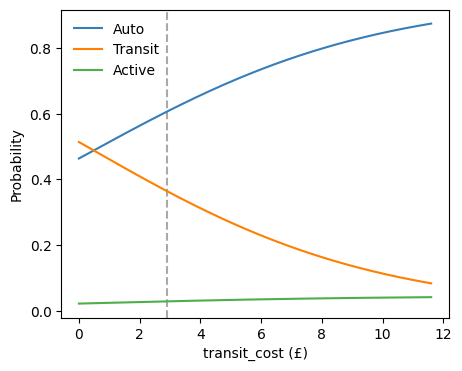

In [ ]:
# MNL model
l_prb_MNL = mnl.predict(data1_prb_lg).reshape(len(data1_prb), 3)
RUM_sub(l_prb_MNL, 'MNL')

In [ ]:
# MXL model
# l_prb_MXL = mxl.predict(data1_prb_lg, num_draws=500, seed=13).reshape(len(data1_prb), 3)
# RUM_sub(l_prb_MXL, 'MXL')

In [ ]:
data1_train_reg = gen_reg_df(data1_train, upper1, lower1)
data1_val_reg = gen_reg_df(data1_val, upper1, lower1)
data1_test_reg = gen_reg_df(data1_test, upper1, lower1)

data1_train_reg_lg = convert(data1_train_reg)
data1_val_reg_lg = convert(data1_val_reg)
data1_test_reg_lg = convert(data1_test_reg)

In [ ]:
eps = (lower1 - upper1) / 5e5

def cal_reg(l_prb_reg):
    'Function to calculate strong and weak regularities'
    diff = np.subtract(l_prb_reg[1::2], l_prb_reg[::2])
    reg_st = sum(diff < eps) / len(diff)
    reg_wk = sum(diff < -eps) / len(diff)
    print(f'Strong regularity = {reg_st:.3f}')
    print(f'Weak regularity   = {reg_wk:.3f}')
    return [reg_st, reg_wk]

In [ ]:
# MNL model
print('Training set:')
prb_reg = mnl.predict(data1_train_reg_lg).reshape(2*train_size, 3)[:, alt]
met_train_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nValidation set:')
prb_reg = mnl.predict(data1_val_reg_lg).reshape(2*val_size, 3)[:, alt]
met_val_mnl.extend(cal_reg(prb_reg))

print('-'*30, '\nTest set:')
prb_reg = mnl.predict(data1_test_reg_lg).reshape(2*test_size, 3)[:, alt]
met_test_mnl.extend(cal_reg(prb_reg))

Training set:
Strong regularity = 0.997
Weak regularity   = 1.000
------------------------------ 
Validation set:
Strong regularity = 0.996
Weak regularity   = 1.000
------------------------------ 
Test set:
Strong regularity = 0.980
Weak regularity   = 1.000


In [ ]:
# MXL model
# print('Training set:')
# prb_reg = mxl.predict(data1_train_reg_lg, num_draws=500, seed=13).reshape(2*train_size, 3)[:, alt]
# met_train_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nValidation set:')
# prb_reg = mxl.predict(data1_val_reg_lg, num_draws=500, seed=13).reshape(2*val_size, 3)[:, alt]
# met_val_mxl.extend(cal_reg(prb_reg))

# print('-'*30, '\nTest set:')
# prb_reg = mxl.predict(data1_test_reg_lg, num_draws=500, seed=13).reshape(2*test_size, 3)[:, alt]
# met_test_mxl.extend(cal_reg(prb_reg))

In [ ]:
l_index = ['Log-likelihood', 'Accuracy', 'F1 score', 'Strong regularity', 'Weak regularity']

# results_train = pd.DataFrame({'MNL': met_train_mnl, 'MXL': met_train_mxl}, index=l_index)
# results_val = pd.DataFrame({'MNL': met_val_mnl, 'MXL': met_val_mxl}, index=l_index)
# results_test = pd.DataFrame({'MNL': met_test_mnl, 'MXL': met_test_mxl}, index=l_index)

results_train = pd.DataFrame({'MNL': met_train_mnl}, index=l_index)
results_val = pd.DataFrame({'MNL': met_val_mnl}, index=l_index)
results_test = pd.DataFrame({'MNL': met_test_mnl}, index=l_index)

results_train_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_val_std = pd.DataFrame({'MNL': 0}, index=l_index)
results_test_std = pd.DataFrame({'MNL': 0}, index=l_index)

# Neural networks (NNs)

## Model structure

In [ ]:
def cal_loss(model, X, y, GR, base, lambd, criterion):
    '''
    Function to regularize the loss function
    lambd: weight of GR -> (1-lambd) is the weight of loss
    base: indicator of regularizing the sum
    '''
    loss = criterion(model(X), y)
    # Utility GR
    if GR == 'UGR':
        utl = model(X)
        g1 = grad(utl[:, 0], X, torch.ones_like(utl[:, 0]), create_graph=True)[0][:, 7:9]
        g2 = grad(utl[:, 1], X, torch.ones_like(utl[:, 1]), create_graph=True)[0][:, 9:11]
        g3 = grad(utl[:, 2], X, torch.ones_like(utl[:, 2]), create_graph=True)[0][:, 11]
    # Probability GR
    elif GR == 'PGR':
        prb = softmax(model(X), dim=1)
        g1 = grad(prb[:, 0], X, torch.ones_like(prb[:, 0]), create_graph=True)[0][:, 7:9]
        g2 = grad(prb[:, 1], X, torch.ones_like(prb[:, 1]), create_graph=True)[0][:, 9:11]
        g3 = grad(prb[:, 2], X, torch.ones_like(prb[:, 2]), create_graph=True)[0][:, 11]
    # Loss GR
    elif GR == 'LGR':
        log_prb = torch.log(softmax(model(X), dim=1))
        g1 = grad(log_prb[:, 0]*(y==0), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 7:9]
        g2 = grad(log_prb[:, 1]*(y==1), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 9:11]
        g3 = grad(log_prb[:, 2]*(y==2), X, torch.ones_like(log_prb[:, 0]), create_graph=True)[0][:, 11]
    # Without GR
    else:
        return loss

    # Sum- vs. norm-GR
    if base == 'sum':
        reg = g1[g1 > 0].sum() + g2[g2 > 0].sum() + g3[g3 > 0].sum()
    else:
        reg = torch.pow(g1, 2).sum() + torch.pow(g2, 2).sum() + torch.pow(g3, 2).sum()
    return loss + lambd * reg

In [ ]:
def train_loop(model, GR, base, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for X, y in train_loader:
        loss = cal_loss(model, X, y, GR, base, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss

In [ ]:
def cal_metrics(model, criterion, loader):
    ll = 0
    y_true, y_pred = [], []
    for X, y in loader:
        pred = model(X)
        y_true.extend(y)
        loss = criterion(pred, y).item()
        ll -= loss * len(X)
        y_pred.extend(pred.argmax(1))
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    return ll, acc, f1, loss

In [ ]:
def test(model, criterion):
    'Function for NN testing'
    model.eval()
    with torch.no_grad():
        # For loss, accuracy, and F1 score calculation
        met_train = cal_metrics(model, criterion, train_loader)
        met_val = cal_metrics(model, criterion, val_loader)
        met_test = cal_metrics(model, criterion, test_loader)

        # For probability calculation
        for X, _ in prb_loader:
            prb = softmax(model(X), dim=1).detach().numpy()

        # For regularity calculation
        for X_train, _ in train_reg_loader:
            prb_reg_train = softmax(model(X_train), dim=1)[:, alt].detach().numpy()
        for X_val, _ in val_reg_loader:
            prb_reg_val = softmax(model(X_val), dim=1)[:, alt].detach().numpy()
        for X_test, _ in test_reg_loader:
            prb_reg_test = softmax(model(X_test), dim=1)[:, alt].detach().numpy()
    return met_train, met_val, met_test, prb, prb_reg_train, prb_reg_val, prb_reg_test

In [ ]:
def plot_loss(agg_loss):
    'Function to plot training and validation losses per epoch'
    for l_loss in agg_loss:
        plt.plot(range(1, len(l_loss[0])+1), l_loss[0], color=l_color[0], alpha=.2)
        plt.plot(range(1, len(l_loss[1])+1), l_loss[1], color=l_color[1], alpha=.2)
    plt.xlabel('Epoch')
    plt.ylabel('Cross-entropy loss')
    plt.show()

In [ ]:
num_models = 10

def train(NN, num_epochs, GR, base, lambd):
    'Function for NN training'
    agg_loss, l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = [[] for i in range(8)]
    for m in range(1, num_models+1):
        torch.manual_seed(m)
        model = NN()
        l_loss_train_epoch, l_loss_val_epoch = [], []
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0)
        criterion = nn.CrossEntropyLoss()
        for i in range(num_epochs):
            l_loss_train_epoch.append(train_loop(model, GR, base, lambd, optimizer, criterion).detach().numpy())
            model.eval()
            with torch.no_grad():
                l_loss_val_epoch.append(cal_metrics(model, criterion, val_loader)[3])
            model.train()
        agg_loss.append([l_loss_train_epoch, l_loss_val_epoch])
        met_train, met_val, met_test, prb, reg_train, reg_val, reg_test = test(model, criterion)
        [x.append(y) for x, y in zip([l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test],
                                     [met_train, met_val, met_test, prb, reg_train, reg_val, reg_test])]
        print(f'Model {m:<2}')
        print_metrics(met_train, met_val, met_test)
    plot_loss(agg_loss)
    return l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test

## Functions for analysis
We evaluate the models by:
- test loss, accuracy, and F1 score;
- strong and weak regularities.

In [ ]:
def NN_agg(l_met):
    'Function to analyze aggregate NN performance'
    # Averages
    avg_ll = np.mean([r[0] for r in l_met])
    avg_acc = np.mean([r[1] for r in l_met])
    avg_f1 = np.mean([r[2] for r in l_met])
    # Standard deviations
    std_ll = np.std([r[0] for r in l_met])
    std_acc = np.std([r[1] for r in l_met])
    std_f1 = np.std([r[2] for r in l_met])
    print(f'Average log-likelihood = {avg_ll:.1f} ({std_ll:.1f})')
    print(f'Average accuracy       = {avg_acc:.1%} ({std_acc:.1%})')
    print(f'Average F1 score       = {avg_f1:.1%} ({std_f1:.1%})')
    return [avg_ll, avg_acc, avg_f1], [std_ll, std_acc, std_f1]

In [ ]:
def NN_sub(l_prb, NN, base, GR, lambd):
    'Function to plot substitution patterns'
    plt.axvline(thr, ls='--', color='darkgray')
    for a in range(3):
        for p in l_prb[:, :, a]:
            plt.plot(data1_prb[var], p, color=l_color[a], alpha=.10)
        plt.plot(data1_prb[var], np.mean(l_prb[:, :, a], axis=0), color=l_color[a], label=l_alt[a])
    plt.legend(frameon=False)
    plt.xlabel(f'{var} (£)')
    plt.ylabel('Probability')
    if GR == 'none':
        plt.savefig(f'{path}/Regularity_results_L/{NN.__name__}_10K_S_L.png', bbox_inches='tight', dpi=200)
    else:
        plt.savefig(f'{path}/Regularity_results_L/{NN.__name__}_{base}_{GR}_{lambd}_10K_S_L.png', bbox_inches='tight', dpi=200)
    plt.show()

In [ ]:
def NN_reg(l_prb_reg):
    'Function to calculate strong and weak regularities for NNs'
    l_st_reg, l_wk_reg = [], []
    for prb_reg in l_prb_reg:
        diff = np.subtract(prb_reg[1::2], prb_reg[::2])
        l_st_reg.append(sum(diff < eps) / len(diff))
        l_wk_reg.append(sum(diff < -eps) / len(diff))
    avg_st_reg = np.mean(l_st_reg)
    avg_wk_reg = np.mean(l_wk_reg)
    std_st_reg = np.std(l_st_reg)
    std_wk_reg = np.std(l_wk_reg)
    print(f'Strong regularity = {avg_st_reg:.3f} ({std_st_reg:.3f})')
    print(f'Weak regularity   = {avg_wk_reg:.3f} ({std_wk_reg:.3f})')
    return [avg_st_reg, avg_wk_reg], [std_st_reg, std_wk_reg]

In [ ]:
def comparison(lambdas, agg_ll, agg_acc, agg_f1, l_st_reg, l_wk_reg, NN, base, GR):
    'Function to compare NN models'
    print('-'*30, '\nModel comparison:')
    fig, ax1 = plt.subplots()

    # Plot average test log-likelihood
    ax1.grid(linestyle='--', color='lightgray')
    ax1.plot(np.log10(lambdas), agg_ll, marker='.', color=l_color[0], label='Log-likelihood')
    ax1.set_xlabel(r'$\lg(\lambda)$')
    ax1.set_ylabel('Test log-likelihood (average)')

    # Plot average test accuracy
    ax2 = ax1.twinx()
    ax2.plot(np.log10(lambdas), agg_acc, marker='.', color=l_color[1], label='Accuracy')
    ax2.set_ylabel(r'Test accuracy, $F_1$ score, regularities (average)')

    # Plot average test F1 score
    ax2.plot(np.log10(lambdas), agg_f1, marker='.', color=l_color[2], label=r'$F_1$ score')

    # Plot average regularities
    ax2.plot(np.log10(lambdas), l_st_reg, marker='.', linestyle='dashed', color=l_color[3], label='Strong regularity')
    ax2.plot(np.log10(lambdas), l_wk_reg, marker='.', linestyle='dashed', color=l_color[4], label='Weak regularity')

    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    box = ax1.get_position()
    ax1.legend(h1+h2, l1+l2, frameon=False, loc='upper center', bbox_to_anchor=(.5, -.15), ncol=2)
    fig.savefig(f'{path}/Regularity_results_L/{NN.__name__}_{base}_{GR}_10K_S_L.png', bbox_inches='tight', dpi=200)

In [ ]:
def result(NN, num_epochs, GR, lambdas=[0], base='sum'):
    'Function to display all DNN results'
    agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg = [[] for i in range(5)]
    for lambd in lambdas:
        print(f'Penalty = {lambd}')
        print('-'*30)
        if NN == DNN and lambd > 1:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs+20, GR, base, lambd)
        else:
            l_met_train, l_met_val, l_met_test, l_prb, l_prb_reg_train, l_prb_reg_val, l_prb_reg_test = train(NN, num_epochs, GR, base, lambd)
        # Average LL, accuracy, and F1 score
        print('-'*30, '\nTraining set:')
        avg_met_train, std_met_train = NN_agg(l_met_train)
        print('-'*30, '\nValidation set:')
        avg_met_val, std_met_val = NN_agg(l_met_val)
        print('-'*30, '\nTest set:')
        avg_met_test, std_met_test = NN_agg(l_met_test)
        [x.append(y) for x, y in zip([agg_ll_test, agg_acc_test, agg_f1_test], avg_met_test)]

        # Regularities
        if GR == 'none':
            name = f'{NN.__name__}'
        else:
            name = f'{NN.__name__}, {base}-{GR} ({lambd})'
        print('-'*30, '\nTraining set:')
        [x.extend(y) for x, y in zip([avg_met_train, std_met_train], NN_reg(l_prb_reg_train))]
        results_train[name] = avg_met_train
        results_train_std[name] = std_met_train
        print('-'*30, '\nValidation set:')
        [x.extend(y) for x, y in zip([avg_met_val, std_met_val], NN_reg(l_prb_reg_val))]
        results_val[name] = avg_met_val
        results_val_std[name] = std_met_val
        print('-'*30, '\nTest set:')
        avg_reg, std_reg = NN_reg(l_prb_reg_test)
        [x.extend(y) for x, y in zip([avg_met_test, std_met_test], [avg_reg, std_reg])]
        results_test[name] = avg_met_test
        results_test_std[name] = std_met_test
        [x.append(y) for x, y in zip([l_st_reg, l_wk_reg], avg_reg)]

        # Substitution pattern
        print('-'*30)
        NN_sub(np.array(l_prb), NN, base, GR, lambd)
    if len(lambdas) > 1:
        comparison(lambdas, agg_ll_test, agg_acc_test, agg_f1_test, l_st_reg, l_wk_reg, NN, base, GR)

## Deep neural networks (DNNs)

In [ ]:
class DNN(nn.Module):
    'Class of DNNs (4 hidden layers x 100 neurons)'
    def __init__(self):
        super(DNN, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(12, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 3)
        )

    def forward(self, x):
        return self.seq(x)

### Without GR

In [ ]:
result(DNN, 15, 'none')

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4562.7 | acc = 72.5% | F1 = 72.2%
Validation set: LL = -699.6  | acc = 68.5% | F1 = 68.1%
Test set:       LL = -1155.7 | acc = 77.0% | F1 = 76.3%
Model 2 
Training set:   LL = -4559.6 | acc = 72.6% | F1 = 72.3%
Validation set: LL = -700.2  | acc = 69.3% | F1 = 69.0%
Test set:       LL = -1121.3 | acc = 77.3% | F1 = 76.8%
Model 3 
Training set:   LL = -4545.9 | acc = 72.4% | F1 = 72.1%
Validation set: LL = -697.1  | acc = 69.4% | F1 = 69.1%
Test set:       LL = -1193.8 | acc = 76.7% | F1 = 75.9%
Model 4 
Training set:   LL = -4539.9 | acc = 72.7% | F1 = 72.4%
Validation set: LL = -696.4  | acc = 69.7% | F1 = 69.4%
Test set:       LL = -1170.3 | acc = 76.6% | F1 = 75.4%
Model 5 
Training set:   LL = -4554.5 | acc = 72.7% | F1 = 72.4%
Validation set: LL = -698.0  | acc = 69.2% | F1 = 68.9%
Test set:       LL = -1154.7 | acc = 76.8% | F1 = 75.5%
Model 6 
Training set:   LL = -4551.3 | acc = 72.6% | F1 = 72.3%
Validat

------------------------------ 
Training set:
Average log-likelihood = -4554.5 (11.1)
Average accuracy       = 72.5% (0.2%)
Average F1 score       = 72.2% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -698.5 (2.2)
Average accuracy       = 69.1% (0.4%)
Average F1 score       = 68.8% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1137.9 (34.3)
Average accuracy       = 77.7% (1.0%)
Average F1 score       = 76.8% (1.1%)
------------------------------ 
Training set:
Strong regularity = 0.736 (0.060)
Weak regularity   = 0.751 (0.054)
------------------------------ 
Validation set:
Strong regularity = 0.724 (0.062)
Weak regularity   = 0.739 (0.054)
------------------------------ 
Test set:
Strong regularity = 0.185 (0.075)
Weak regularity   = 0.207 (0.080)
------------------------------


### PGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -6058.4 | acc = 60.9% | F1 = 51.8%
Validation set: LL = -868.7  | acc = 60.9% | F1 = 52.1%
Test set:       LL = -1241.5 | acc = 76.1% | F1 = 74.2%
Model 2 
Training set:   LL = -6201.6 | acc = 61.5% | F1 = 54.2%
Validation set: LL = -896.4  | acc = 61.4% | F1 = 54.3%
Test set:       LL = -1542.1 | acc = 74.2% | F1 = 72.3%
Model 3 
Training set:   LL = -6097.2 | acc = 60.2% | F1 = 51.7%
Validation set: LL = -885.3  | acc = 60.2% | F1 = 51.9%
Test set:       LL = -1594.3 | acc = 71.4% | F1 = 68.9%
Model 4 
Training set:   LL = -5991.3 | acc = 60.9% | F1 = 51.9%
Validation set: LL = -859.7  | acc = 60.6% | F1 = 52.0%
Test set:       LL = -1449.0 | acc = 70.5% | F1 = 67.9%
Model 5 
Training set:   LL = -6045.7 | acc = 60.6% | F1 = 53.1%
Validation set: LL = -872.2  | acc = 61.0% | F1 = 53.4%
Test set:       LL = -1582.2 | acc = 67.5% | F1 = 64.3%
Model 6 
Training set:   LL = -5863.2 | acc = 62.3% | F1 = 55.1%
Valid

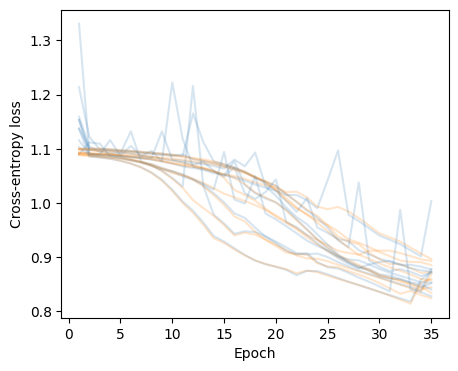

------------------------------ 
Training set:
Average log-likelihood = -5958.2 (176.8)
Average accuracy       = 61.5% (1.4%)
Average F1 score       = 54.1% (2.7%)
------------------------------ 
Validation set:
Average log-likelihood = -863.5 (23.2)
Average accuracy       = 61.3% (1.0%)
Average F1 score       = 54.1% (2.5%)
------------------------------ 
Test set:
Average log-likelihood = -1460.9 (175.3)
Average accuracy       = 72.3% (4.7%)
Average F1 score       = 69.8% (5.5%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------


Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4929.7 | acc = 70.2% | F1 = 69.2%
Validation set: LL = -733.5  | acc = 67.5% | F1 = 66.4%
Test set:       LL = -1144.0 | acc = 78.2% | F1 = 76.5%
Model 2 
Training set:   LL = -4887.8 | acc = 70.8% | F1 = 70.3%
Validation set: LL = -733.5  | acc = 68.7% | F1 = 68.2%
Test set:       LL = -1205.1 | acc = 76.1% | F1 = 74.4%
Model 3 
Training set:   LL = -5085.4 | acc = 69.9% | F1 = 69.4%
Validation set: LL = -752.5  | acc = 67.4% | F1 = 67.0%
Test set:       LL = -1213.1 | acc = 76.0% | F1 = 74.1%
Model 4 
Training set:   LL = -4809.7 | acc = 70.8% | F1 = 70.3%
Validation set: LL = -732.9  | acc = 69.1% | F1 = 68.6%
Test set:       LL = -1190.6 | acc = 76.3% | F1 = 75.0%
Model 5 
Training set:   LL = -5094.2 | acc = 67.9% | F1 = 66.9%
Validation set: LL = -769.9  | acc = 65.2% | F1 = 64.1%
Test set:       LL = -1219.7 | acc = 75.8% | F1 = 74.1%
Model 6 
Training set:   LL = -4762.9 | acc = 71.8% | F1 = 71.4%
Valida

------------------------------ 
Training set:
Average log-likelihood = -4912.4 (114.1)
Average accuracy       = 70.2% (1.0%)
Average F1 score       = 69.6% (1.2%)
------------------------------ 
Validation set:
Average log-likelihood = -737.6 (15.2)
Average accuracy       = 67.9% (1.2%)
Average F1 score       = 67.2% (1.5%)
------------------------------ 
Test set:
Average log-likelihood = -1165.7 (49.2)
Average accuracy       = 77.3% (1.4%)
Average F1 score       = 75.6% (1.5%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.998 (0.002)
Weak regularity   = 1.000 (0.001)
------------------------------


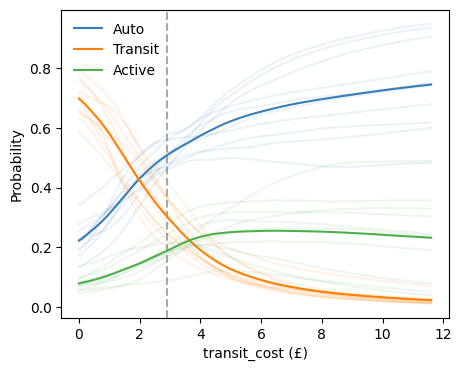

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4942.3 | acc = 69.4% | F1 = 67.7%
Validation set: LL = -731.0  | acc = 66.6% | F1 = 64.7%
Test set:       LL = -1155.7 | acc = 77.7% | F1 = 76.1%
Model 2 
Training set:   LL = -4896.7 | acc = 69.8% | F1 = 68.5%
Validation set: LL = -733.6  | acc = 66.3% | F1 = 64.9%
Test set:       LL = -1145.4 | acc = 78.0% | F1 = 76.4%
Model 3 
Training set:   LL = -4989.4 | acc = 69.7% | F1 = 69.1%
Validation set: LL = -737.8  | acc = 67.1% | F1 = 66.5%
Test set:       LL = -1128.7 | acc = 79.2% | F1 = 77.5%
Model 4 
Training set:   LL = -4888.9 | acc = 70.2% | F1 = 69.1%
Validation set: LL = -724.6  | acc = 69.2% | F1 = 68.4%
Test set:       LL = -1130.5 | acc = 79.1% | F1 = 77.5%
Model 5 
Training set:   LL = -4856.6 | acc = 70.2% | F1 = 69.4%
Validation set: LL = -731.1  | acc = 68.2% | F1 = 67.3%
Test set:       LL = -1113.0 | acc = 78.1% | F1 = 76.5%
Model 6 
Training set:   LL = -4935.4 | acc = 70.0% | F1 = 69.4%
Validat

------------------------------ 
Training set:
Average log-likelihood = -4892.1 (70.2)
Average accuracy       = 70.2% (0.6%)
Average F1 score       = 69.4% (0.9%)
------------------------------ 
Validation set:
Average log-likelihood = -730.1 (10.8)
Average accuracy       = 67.7% (1.0%)
Average F1 score       = 67.0% (1.3%)
------------------------------ 
Test set:
Average log-likelihood = -1126.3 (19.2)
Average accuracy       = 78.7% (0.7%)
Average F1 score       = 77.2% (0.8%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.994 (0.007)
Weak regularity   = 0.997 (0.005)
------------------------------


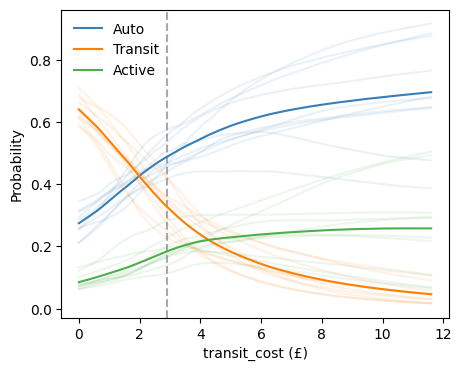

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4600.9 | acc = 72.0% | F1 = 71.7%
Validation set: LL = -696.9  | acc = 70.0% | F1 = 69.6%
Test set:       LL = -1122.9 | acc = 78.0% | F1 = 77.2%
Model 2 
Training set:   LL = -4572.3 | acc = 72.3% | F1 = 72.0%
Validation set: LL = -701.6  | acc = 69.1% | F1 = 68.8%
Test set:       LL = -1157.2 | acc = 77.1% | F1 = 76.6%
Model 3 
Training set:   LL = -4625.1 | acc = 72.4% | F1 = 71.9%
Validation set: LL = -702.8  | acc = 69.4% | F1 = 68.9%
Test set:       LL = -1080.1 | acc = 79.2% | F1 = 78.3%
Model 4 
Training set:   LL = -4574.0 | acc = 72.4% | F1 = 72.1%
Validation set: LL = -697.8  | acc = 69.7% | F1 = 69.4%
Test set:       LL = -1089.6 | acc = 79.0% | F1 = 78.0%
Model 5 
Training set:   LL = -4578.3 | acc = 72.4% | F1 = 72.1%
Validation set: LL = -697.8  | acc = 69.9% | F1 = 69.5%
Test set:       LL = -1104.4 | acc = 77.8% | F1 = 76.6%
Model 6 
Training set:   LL = -4591.9 | acc = 72.2% | F1 = 71.9%
Valid

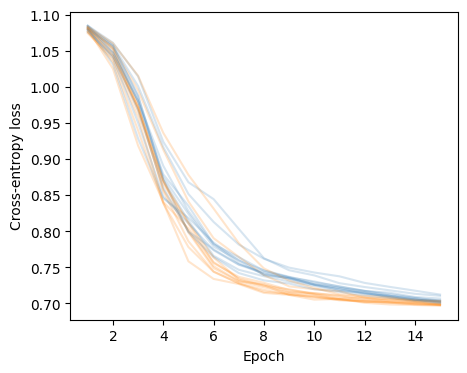

------------------------------ 
Training set:
Average log-likelihood = -4589.4 (25.8)
Average accuracy       = 72.2% (0.2%)
Average F1 score       = 71.9% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -699.7 (2.2)
Average accuracy       = 69.3% (0.5%)
Average F1 score       = 69.0% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1110.4 (23.9)
Average accuracy       = 78.4% (0.7%)
Average F1 score       = 77.6% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 0.999 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.001)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.968 (0.032)
Weak regularity   = 0.977 (0.026)
------------------------------


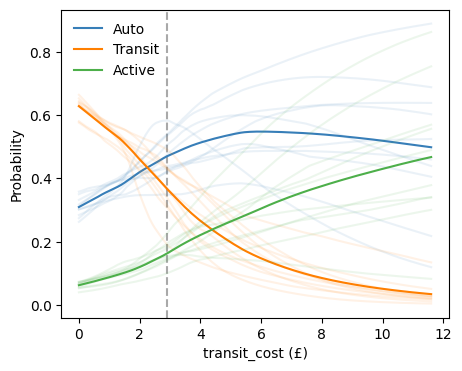

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4531.1 | acc = 72.4% | F1 = 72.2%
Validation set: LL = -693.4  | acc = 69.2% | F1 = 68.9%
Test set:       LL = -1102.9 | acc = 78.2% | F1 = 77.4%
Model 2 
Training set:   LL = -4514.9 | acc = 72.4% | F1 = 72.2%
Validation set: LL = -699.9  | acc = 69.3% | F1 = 69.1%
Test set:       LL = -1163.4 | acc = 76.8% | F1 = 76.5%
Model 3 
Training set:   LL = -4514.6 | acc = 72.7% | F1 = 72.4%
Validation set: LL = -695.7  | acc = 69.0% | F1 = 68.8%
Test set:       LL = -1107.5 | acc = 78.1% | F1 = 77.8%
Model 4 
Training set:   LL = -4513.4 | acc = 72.9% | F1 = 72.7%
Validation set: LL = -693.9  | acc = 69.6% | F1 = 69.3%
Test set:       LL = -1084.1 | acc = 78.9% | F1 = 78.2%
Model 5 
Training set:   LL = -4526.8 | acc = 72.6% | F1 = 72.4%
Validation set: LL = -694.8  | acc = 69.9% | F1 = 69.7%
Test set:       LL = -1094.3 | acc = 77.9% | F1 = 77.2%
Model 6 
Training set:   LL = -4533.6 | acc = 72.4% | F1 = 72.2%
Vali

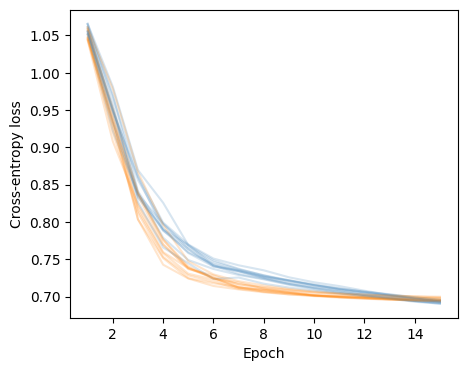

------------------------------ 
Training set:
Average log-likelihood = -4521.5 (8.7)
Average accuracy       = 72.5% (0.2%)
Average F1 score       = 72.3% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -696.1 (2.2)
Average accuracy       = 69.3% (0.3%)
Average F1 score       = 69.0% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1114.4 (23.4)
Average accuracy       = 78.1% (0.6%)
Average F1 score       = 77.5% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.993 (0.003)
Weak regularity   = 0.995 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.992 (0.004)
Weak regularity   = 0.994 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.904 (0.064)
Weak regularity   = 0.919 (0.059)
------------------------------


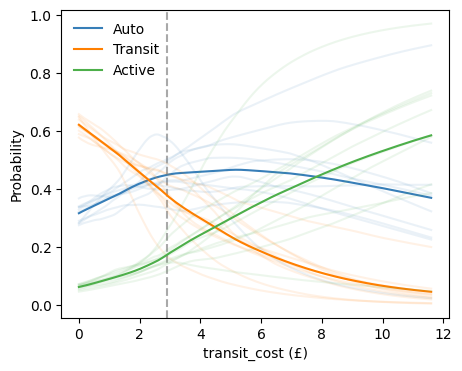

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4528.4 | acc = 72.4% | F1 = 72.2%
Validation set: LL = -695.1  | acc = 68.9% | F1 = 68.7%
Test set:       LL = -1097.8 | acc = 77.9% | F1 = 77.3%
Model 2 
Training set:   LL = -4512.9 | acc = 72.7% | F1 = 72.5%
Validation set: LL = -698.6  | acc = 68.9% | F1 = 68.7%
Test set:       LL = -1143.5 | acc = 77.3% | F1 = 77.1%
Model 3 
Training set:   LL = -4519.0 | acc = 72.3% | F1 = 72.0%
Validation set: LL = -696.4  | acc = 68.8% | F1 = 68.5%
Test set:       LL = -1103.2 | acc = 78.0% | F1 = 77.5%
Model 4 
Training set:   LL = -4522.7 | acc = 72.8% | F1 = 72.5%
Validation set: LL = -695.5  | acc = 70.3% | F1 = 70.0%
Test set:       LL = -1063.7 | acc = 79.3% | F1 = 78.5%
Model 5 
Training set:   LL = -4524.0 | acc = 72.6% | F1 = 72.4%
Validation set: LL = -695.0  | acc = 69.8% | F1 = 69.6%
Test set:       LL = -1102.9 | acc = 77.8% | F1 = 77.4%
Model 6 
Training set:   LL = -4527.2 | acc = 72.8% | F1 = 72.5%
Val

------------------------------ 
Training set:
Average log-likelihood = -4523.4 (5.0)
Average accuracy       = 72.6% (0.1%)
Average F1 score       = 72.3% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -695.9 (1.7)
Average accuracy       = 69.3% (0.5%)
Average F1 score       = 69.0% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1092.9 (22.4)
Average accuracy       = 78.5% (0.7%)
Average F1 score       = 77.9% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.954 (0.011)
Weak regularity   = 0.959 (0.008)
------------------------------ 
Validation set:
Strong regularity = 0.952 (0.017)
Weak regularity   = 0.957 (0.014)
------------------------------ 
Test set:
Strong regularity = 0.685 (0.141)
Weak regularity   = 0.715 (0.135)
------------------------------


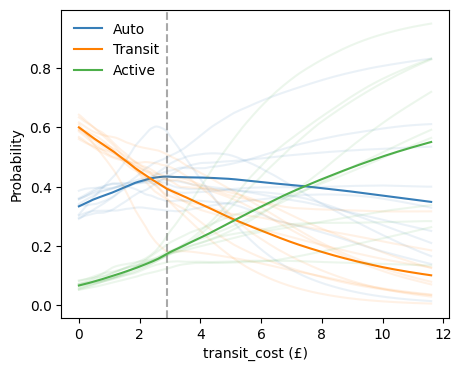

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4545.1 | acc = 72.7% | F1 = 72.4%
Validation set: LL = -697.8  | acc = 68.6% | F1 = 68.2%
Test set:       LL = -1117.4 | acc = 77.9% | F1 = 77.3%
Model 2 
Training set:   LL = -4534.9 | acc = 72.7% | F1 = 72.4%
Validation set: LL = -698.0  | acc = 69.8% | F1 = 69.5%
Test set:       LL = -1117.2 | acc = 78.2% | F1 = 78.0%
Model 3 
Training set:   LL = -4523.6 | acc = 72.8% | F1 = 72.5%
Validation set: LL = -696.0  | acc = 68.8% | F1 = 68.5%
Test set:       LL = -1145.3 | acc = 77.1% | F1 = 76.5%
Model 4 
Training set:   LL = -4526.7 | acc = 72.8% | F1 = 72.5%
Validation set: LL = -694.7  | acc = 69.4% | F1 = 69.1%
Test set:       LL = -1113.1 | acc = 77.8% | F1 = 76.8%
Model 5 
Training set:   LL = -4537.4 | acc = 72.6% | F1 = 72.4%
Validation set: LL = -697.1  | acc = 70.0% | F1 = 69.7%
Test set:       LL = -1103.4 | acc = 78.1% | F1 = 77.2%
Model 6 
Training set:   LL = -4537.5 | acc = 72.7% | F1 = 72.4%
Va

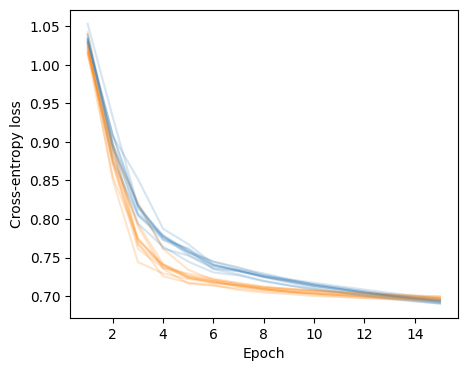

------------------------------ 
Training set:
Average log-likelihood = -4537.0 (8.6)
Average accuracy       = 72.6% (0.1%)
Average F1 score       = 72.4% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -696.8 (1.9)
Average accuracy       = 69.1% (0.4%)
Average F1 score       = 68.8% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1101.3 (23.5)
Average accuracy       = 78.5% (0.8%)
Average F1 score       = 77.8% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.834 (0.033)
Weak regularity   = 0.844 (0.031)
------------------------------ 
Validation set:
Strong regularity = 0.827 (0.035)
Weak regularity   = 0.838 (0.033)
------------------------------ 
Test set:
Strong regularity = 0.318 (0.133)
Weak regularity   = 0.347 (0.141)
------------------------------


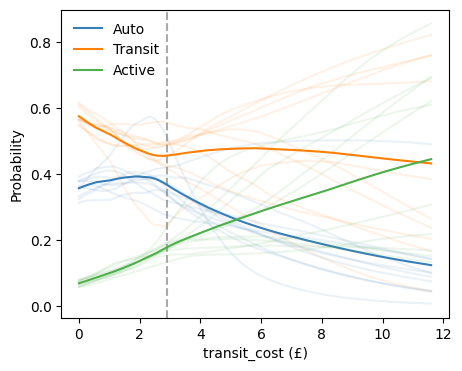

------------------------------ 
Model comparison:


In [ ]:
# With sum
result(DNN, 15, 'PGR', [10**i for i in range(2, -5, -1)])

### UGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -5070.0 | acc = 68.6% | F1 = 67.5%
Validation set: LL = -742.9  | acc = 67.2% | F1 = 66.1%
Test set:       LL = -1129.6 | acc = 78.4% | F1 = 76.7%
Model 2 
Training set:   LL = -5625.1 | acc = 64.0% | F1 = 60.8%
Validation set: LL = -811.3  | acc = 64.3% | F1 = 61.2%
Test set:       LL = -1361.2 | acc = 74.5% | F1 = 72.4%
Model 3 
Training set:   LL = -5612.0 | acc = 64.1% | F1 = 60.3%
Validation set: LL = -811.9  | acc = 63.6% | F1 = 59.9%
Test set:       LL = -1289.4 | acc = 77.0% | F1 = 75.0%
Model 4 
Training set:   LL = -5017.7 | acc = 69.6% | F1 = 69.0%
Validation set: LL = -736.4  | acc = 68.1% | F1 = 67.5%
Test set:       LL = -1160.4 | acc = 77.0% | F1 = 75.1%
Model 5 
Training set:   LL = -5526.6 | acc = 65.1% | F1 = 62.5%
Validation set: LL = -806.6  | acc = 64.3% | F1 = 61.6%
Test set:       LL = -1310.2 | acc = 76.5% | F1 = 74.6%
Model 6 
Training set:   LL = -5221.3 | acc = 68.2% | F1 = 66.7%
Valid

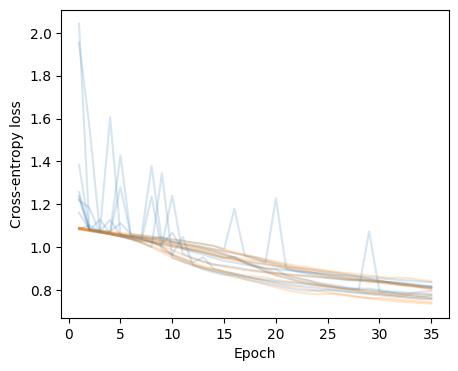

------------------------------ 
Training set:
Average log-likelihood = -5387.4 (240.7)
Average accuracy       = 66.3% (2.3%)
Average F1 score       = 63.8% (3.8%)
------------------------------ 
Validation set:
Average log-likelihood = -785.9 (32.4)
Average accuracy       = 65.2% (1.9%)
Average F1 score       = 62.8% (3.4%)
------------------------------ 
Test set:
Average log-likelihood = -1239.8 (100.0)
Average accuracy       = 76.7% (1.6%)
Average F1 score       = 74.8% (1.7%)
------------------------------ 
Training set:
Strong regularity = 0.982 (0.029)
Weak regularity   = 0.987 (0.021)
------------------------------ 
Validation set:
Strong regularity = 0.984 (0.023)
Weak regularity   = 0.989 (0.017)
------------------------------ 
Test set:
Strong regularity = 0.974 (0.044)
Weak regularity   = 0.981 (0.033)
------------------------------


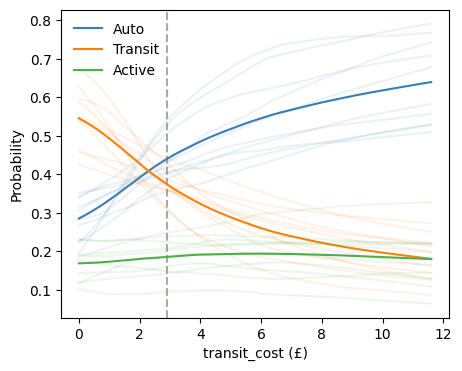

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -4764.6 | acc = 71.3% | F1 = 70.9%
Validation set: LL = -713.2  | acc = 69.3% | F1 = 68.9%
Test set:       LL = -1134.1 | acc = 78.8% | F1 = 78.0%
Model 2 
Training set:   LL = -4878.5 | acc = 70.5% | F1 = 70.0%
Validation set: LL = -715.5  | acc = 69.1% | F1 = 68.7%
Test set:       LL = -1121.0 | acc = 79.3% | F1 = 77.6%
Model 3 
Training set:   LL = -4868.4 | acc = 70.6% | F1 = 70.2%
Validation set: LL = -716.7  | acc = 68.7% | F1 = 68.4%
Test set:       LL = -1111.2 | acc = 79.6% | F1 = 77.8%
Model 4 
Training set:   LL = -4736.8 | acc = 71.5% | F1 = 71.1%
Validation set: LL = -708.5  | acc = 69.6% | F1 = 69.3%
Test set:       LL = -1109.0 | acc = 79.8% | F1 = 78.1%
Model 5 
Training set:   LL = -4830.9 | acc = 70.8% | F1 = 70.3%
Validation set: LL = -715.1  | acc = 69.3% | F1 = 68.9%
Test set:       LL = -1105.1 | acc = 79.6% | F1 = 77.8%
Model 6 
Training set:   LL = -4777.0 | acc = 71.2% | F1 = 70.8%
Valida

------------------------------ 
Training set:
Average log-likelihood = -4806.0 (71.2)
Average accuracy       = 71.0% (0.5%)
Average F1 score       = 70.6% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -713.6 (4.8)
Average accuracy       = 69.1% (0.4%)
Average F1 score       = 68.8% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1108.4 (21.1)
Average accuracy       = 79.4% (0.7%)
Average F1 score       = 77.8% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.991 (0.019)
Weak regularity   = 0.993 (0.016)
------------------------------ 
Validation set:
Strong regularity = 0.991 (0.020)
Weak regularity   = 0.992 (0.018)
------------------------------ 
Test set:
Strong regularity = 0.979 (0.029)
Weak regularity   = 0.984 (0.025)
------------------------------


Penalty = 1
------------------------------
Model 1 
Training set:   LL = -4906.2 | acc = 70.2% | F1 = 69.6%
Validation set: LL = -724.2  | acc = 68.0% | F1 = 67.4%
Test set:       LL = -1121.0 | acc = 79.6% | F1 = 78.1%
Model 2 
Training set:   LL = -5043.9 | acc = 69.3% | F1 = 68.4%
Validation set: LL = -734.4  | acc = 67.5% | F1 = 66.5%
Test set:       LL = -1114.2 | acc = 79.1% | F1 = 77.4%
Model 3 
Training set:   LL = -5180.7 | acc = 68.6% | F1 = 67.7%
Validation set: LL = -758.4  | acc = 66.2% | F1 = 65.4%
Test set:       LL = -1110.9 | acc = 78.7% | F1 = 77.0%
Model 4 
Training set:   LL = -4906.2 | acc = 70.2% | F1 = 69.7%
Validation set: LL = -721.3  | acc = 68.8% | F1 = 68.4%
Test set:       LL = -1147.1 | acc = 79.6% | F1 = 77.9%
Model 5 
Training set:   LL = -4971.7 | acc = 69.5% | F1 = 68.7%
Validation set: LL = -728.0  | acc = 67.2% | F1 = 66.3%
Test set:       LL = -1114.8 | acc = 79.0% | F1 = 77.1%
Model 6 
Training set:   LL = -5074.0 | acc = 68.8% | F1 = 67.7%
Validat

------------------------------ 
Training set:
Average log-likelihood = -5036.7 (120.6)
Average accuracy       = 69.4% (0.7%)
Average F1 score       = 68.6% (0.9%)
------------------------------ 
Validation set:
Average log-likelihood = -738.4 (16.7)
Average accuracy       = 67.4% (1.1%)
Average F1 score       = 66.6% (1.3%)
------------------------------ 
Test set:
Average log-likelihood = -1137.9 (54.5)
Average accuracy       = 78.7% (1.4%)
Average F1 score       = 76.9% (1.4%)
------------------------------ 
Training set:
Strong regularity = 0.996 (0.004)
Weak regularity   = 0.996 (0.003)
------------------------------ 
Validation set:
Strong regularity = 0.996 (0.004)
Weak regularity   = 0.997 (0.004)
------------------------------ 
Test set:
Strong regularity = 0.987 (0.012)
Weak regularity   = 0.992 (0.008)
------------------------------


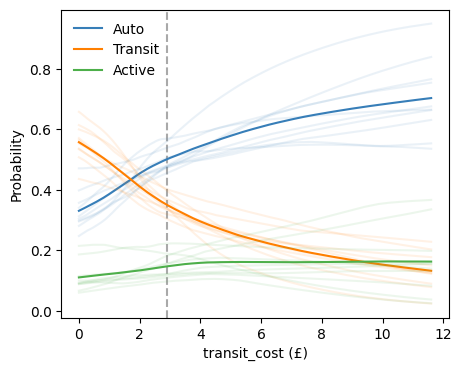

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4688.1 | acc = 71.8% | F1 = 71.3%
Validation set: LL = -703.1  | acc = 69.4% | F1 = 68.9%
Test set:       LL = -1100.4 | acc = 79.0% | F1 = 78.3%
Model 2 
Training set:   LL = -4710.5 | acc = 71.6% | F1 = 71.2%
Validation set: LL = -706.0  | acc = 68.3% | F1 = 68.1%
Test set:       LL = -1079.3 | acc = 79.4% | F1 = 78.1%
Model 3 
Training set:   LL = -4743.8 | acc = 71.1% | F1 = 70.5%
Validation set: LL = -708.6  | acc = 69.6% | F1 = 69.2%
Test set:       LL = -1079.4 | acc = 80.2% | F1 = 78.8%
Model 4 
Training set:   LL = -4695.8 | acc = 71.4% | F1 = 70.7%
Validation set: LL = -704.7  | acc = 69.1% | F1 = 68.4%
Test set:       LL = -1077.0 | acc = 79.8% | F1 = 78.7%
Model 5 
Training set:   LL = -4673.6 | acc = 71.7% | F1 = 71.3%
Validation set: LL = -705.0  | acc = 69.8% | F1 = 69.4%
Test set:       LL = -1074.2 | acc = 79.3% | F1 = 77.9%
Model 6 
Training set:   LL = -4640.2 | acc = 71.8% | F1 = 71.4%
Valid

------------------------------ 
Training set:
Average log-likelihood = -4697.8 (34.8)
Average accuracy       = 71.5% (0.3%)
Average F1 score       = 71.0% (0.4%)
------------------------------ 
Validation set:
Average log-likelihood = -705.6 (3.5)
Average accuracy       = 69.2% (0.5%)
Average F1 score       = 68.7% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1079.5 (11.8)
Average accuracy       = 79.5% (0.5%)
Average F1 score       = 78.5% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.967 (0.033)
Weak regularity   = 0.971 (0.030)
------------------------------ 
Validation set:
Strong regularity = 0.963 (0.040)
Weak regularity   = 0.967 (0.036)
------------------------------ 
Test set:
Strong regularity = 0.846 (0.091)
Weak regularity   = 0.871 (0.088)
------------------------------


Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4564.6 | acc = 72.4% | F1 = 72.1%
Validation set: LL = -695.4  | acc = 70.0% | F1 = 69.7%
Test set:       LL = -1085.0 | acc = 78.8% | F1 = 78.3%
Model 2 
Training set:   LL = -4542.8 | acc = 72.4% | F1 = 72.2%
Validation set: LL = -697.6  | acc = 69.3% | F1 = 69.0%
Test set:       LL = -1150.1 | acc = 78.1% | F1 = 78.0%
Model 3 
Training set:   LL = -4572.5 | acc = 72.1% | F1 = 71.7%
Validation set: LL = -699.9  | acc = 69.3% | F1 = 69.0%
Test set:       LL = -1068.8 | acc = 79.3% | F1 = 78.5%
Model 4 
Training set:   LL = -4554.5 | acc = 72.4% | F1 = 72.1%
Validation set: LL = -697.2  | acc = 69.8% | F1 = 69.5%
Test set:       LL = -1082.4 | acc = 78.7% | F1 = 78.1%
Model 5 
Training set:   LL = -4563.5 | acc = 72.4% | F1 = 72.1%
Validation set: LL = -697.3  | acc = 69.8% | F1 = 69.5%
Test set:       LL = -1079.0 | acc = 79.0% | F1 = 78.1%
Model 6 
Training set:   LL = -4545.5 | acc = 72.5% | F1 = 72.2%
Vali

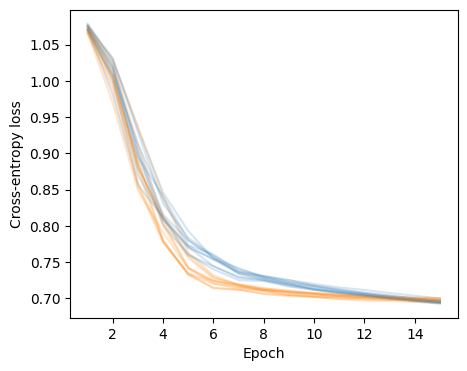

------------------------------ 
Training set:
Average log-likelihood = -4554.2 (11.9)
Average accuracy       = 72.4% (0.1%)
Average F1 score       = 72.1% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -697.3 (1.8)
Average accuracy       = 69.5% (0.3%)
Average F1 score       = 69.2% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1098.1 (26.3)
Average accuracy       = 78.7% (0.6%)
Average F1 score       = 78.2% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.926 (0.024)
Weak regularity   = 0.933 (0.022)
------------------------------ 
Validation set:
Strong regularity = 0.921 (0.029)
Weak regularity   = 0.927 (0.028)
------------------------------ 
Test set:
Strong regularity = 0.646 (0.095)
Weak regularity   = 0.677 (0.093)
------------------------------


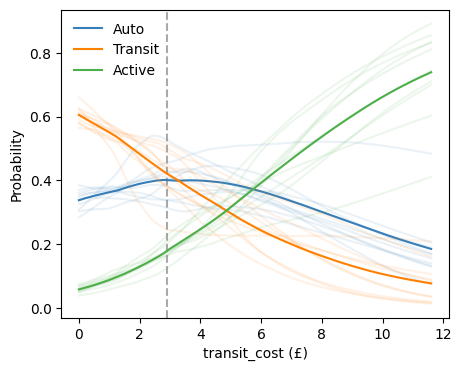

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4536.2 | acc = 72.5% | F1 = 72.2%
Validation set: LL = -696.1  | acc = 69.3% | F1 = 69.0%
Test set:       LL = -1092.3 | acc = 79.0% | F1 = 78.5%
Model 2 
Training set:   LL = -4531.7 | acc = 72.6% | F1 = 72.3%
Validation set: LL = -697.7  | acc = 69.4% | F1 = 69.1%
Test set:       LL = -1132.8 | acc = 78.0% | F1 = 77.9%
Model 3 
Training set:   LL = -4521.8 | acc = 72.4% | F1 = 72.1%
Validation set: LL = -696.3  | acc = 68.9% | F1 = 68.6%
Test set:       LL = -1089.4 | acc = 77.6% | F1 = 77.1%
Model 4 
Training set:   LL = -4527.9 | acc = 72.7% | F1 = 72.4%
Validation set: LL = -695.4  | acc = 69.9% | F1 = 69.6%
Test set:       LL = -1083.9 | acc = 78.8% | F1 = 78.1%
Model 5 
Training set:   LL = -4547.9 | acc = 72.3% | F1 = 72.1%
Validation set: LL = -695.3  | acc = 69.8% | F1 = 69.5%
Test set:       LL = -1078.6 | acc = 79.3% | F1 = 78.5%
Model 6 
Training set:   LL = -4529.9 | acc = 72.7% | F1 = 72.4%
Val

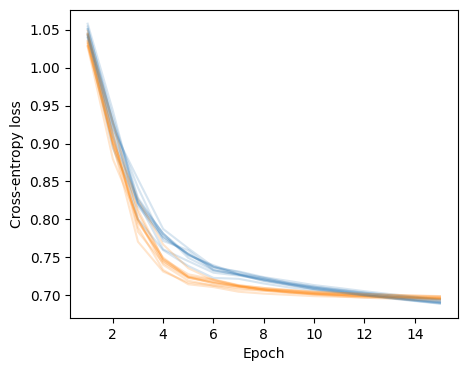

------------------------------ 
Training set:
Average log-likelihood = -4531.8 (9.9)
Average accuracy       = 72.5% (0.1%)
Average F1 score       = 72.2% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -696.3 (1.7)
Average accuracy       = 69.3% (0.4%)
Average F1 score       = 69.0% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1095.8 (15.0)
Average accuracy       = 78.7% (0.5%)
Average F1 score       = 78.2% (0.4%)
------------------------------ 
Training set:
Strong regularity = 0.903 (0.024)
Weak regularity   = 0.910 (0.021)
------------------------------ 
Validation set:
Strong regularity = 0.897 (0.028)
Weak regularity   = 0.904 (0.025)
------------------------------ 
Test set:
Strong regularity = 0.526 (0.122)
Weak regularity   = 0.559 (0.118)
------------------------------


Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4541.0 | acc = 72.7% | F1 = 72.4%
Validation set: LL = -696.5  | acc = 68.6% | F1 = 68.3%
Test set:       LL = -1110.1 | acc = 78.0% | F1 = 77.6%
Model 2 
Training set:   LL = -4530.4 | acc = 72.7% | F1 = 72.5%
Validation set: LL = -697.6  | acc = 69.4% | F1 = 69.1%
Test set:       LL = -1130.2 | acc = 77.6% | F1 = 77.6%
Model 3 
Training set:   LL = -4529.5 | acc = 72.5% | F1 = 72.2%
Validation set: LL = -697.0  | acc = 69.2% | F1 = 68.9%
Test set:       LL = -1111.2 | acc = 77.8% | F1 = 77.3%
Model 4 
Training set:   LL = -4535.5 | acc = 72.7% | F1 = 72.4%
Validation set: LL = -696.5  | acc = 69.9% | F1 = 69.6%
Test set:       LL = -1091.6 | acc = 79.0% | F1 = 78.2%
Model 5 
Training set:   LL = -4542.2 | acc = 72.6% | F1 = 72.3%
Validation set: LL = -698.0  | acc = 69.6% | F1 = 69.4%
Test set:       LL = -1108.2 | acc = 78.6% | F1 = 77.9%
Model 6 
Training set:   LL = -4536.2 | acc = 72.7% | F1 = 72.4%
Va

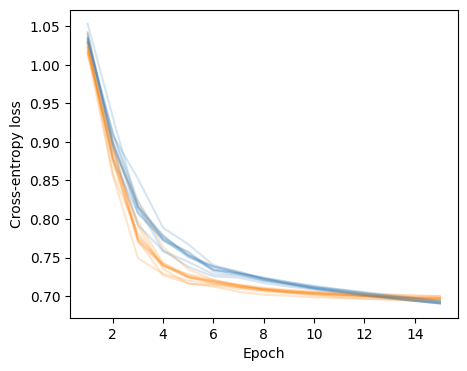

------------------------------ 
Training set:
Average log-likelihood = -4537.0 (5.6)
Average accuracy       = 72.5% (0.2%)
Average F1 score       = 72.3% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -697.1 (2.0)
Average accuracy       = 69.2% (0.4%)
Average F1 score       = 69.0% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1097.8 (17.4)
Average accuracy       = 78.7% (0.6%)
Average F1 score       = 78.1% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.861 (0.022)
Weak regularity   = 0.871 (0.019)
------------------------------ 
Validation set:
Strong regularity = 0.855 (0.025)
Weak regularity   = 0.864 (0.023)
------------------------------ 
Test set:
Strong regularity = 0.396 (0.133)
Weak regularity   = 0.425 (0.136)
------------------------------


------------------------------ 
Model comparison:


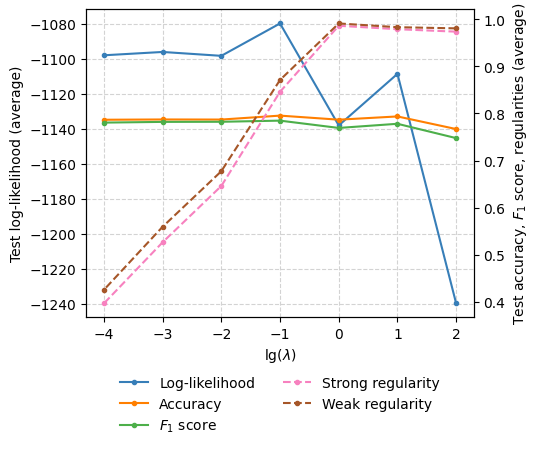

In [ ]:
# With sum
result(DNN, 15, 'UGR', [10**i for i in range(2, -5, -1)])

### LGR

Penalty = 100
------------------------------
Model 1 
Training set:   LL = -6087.5 | acc = 61.1% | F1 = 52.2%
Validation set: LL = -875.3  | acc = 61.2% | F1 = 52.6%
Test set:       LL = -1270.7 | acc = 77.6% | F1 = 75.8%
Model 2 
Training set:   LL = -6769.1 | acc = 62.3% | F1 = 56.7%
Validation set: LL = -972.9  | acc = 61.9% | F1 = 56.2%
Test set:       LL = -1803.4 | acc = 69.6% | F1 = 67.1%
Model 3 
Training set:   LL = -6398.8 | acc = 59.4% | F1 = 50.8%
Validation set: LL = -928.2  | acc = 58.7% | F1 = 50.5%
Test set:       LL = -1699.5 | acc = 69.3% | F1 = 66.4%
Model 4 
Training set:   LL = -5796.0 | acc = 61.5% | F1 = 53.8%
Validation set: LL = -842.3  | acc = 60.0% | F1 = 52.4%
Test set:       LL = -1296.3 | acc = 75.8% | F1 = 73.9%
Model 5 
Training set:   LL = -6595.7 | acc = 60.7% | F1 = 55.5%
Validation set: LL = -953.4  | acc = 61.1% | F1 = 56.0%
Test set:       LL = -1832.7 | acc = 62.7% | F1 = 58.8%
Model 6 
Training set:   LL = -5991.0 | acc = 60.3% | F1 = 51.7%
Valid

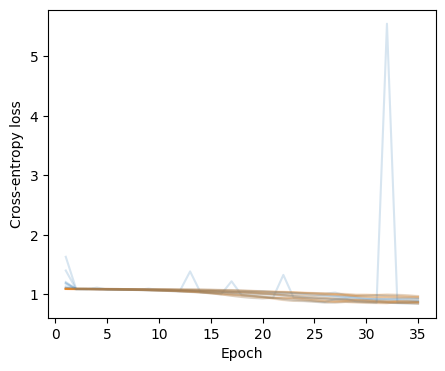

------------------------------ 
Training set:
Average log-likelihood = -6200.4 (325.5)
Average accuracy       = 60.8% (1.7%)
Average F1 score       = 53.9% (3.3%)
------------------------------ 
Validation set:
Average log-likelihood = -899.0 (45.1)
Average accuracy       = 60.2% (1.6%)
Average F1 score       = 53.5% (3.1%)
------------------------------ 
Test set:
Average log-likelihood = -1700.4 (311.4)
Average accuracy       = 67.7% (6.8%)
Average F1 score       = 64.1% (8.5%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


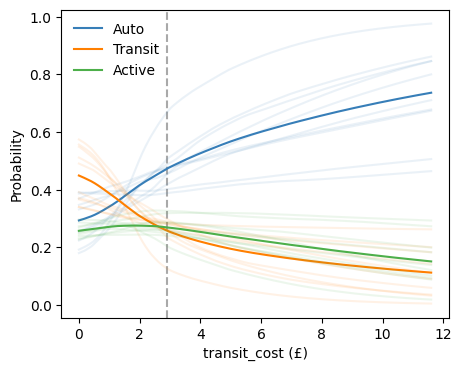

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -5328.3 | acc = 67.4% | F1 = 65.4%
Validation set: LL = -784.3  | acc = 66.8% | F1 = 65.3%
Test set:       LL = -1126.3 | acc = 79.2% | F1 = 77.6%
Model 2 
Training set:   LL = -5167.1 | acc = 68.1% | F1 = 66.9%
Validation set: LL = -783.7  | acc = 65.8% | F1 = 64.5%
Test set:       LL = -1115.4 | acc = 78.4% | F1 = 77.0%
Model 3 
Training set:   LL = -5226.2 | acc = 67.5% | F1 = 65.4%
Validation set: LL = -776.8  | acc = 64.7% | F1 = 62.5%
Test set:       LL = -1258.0 | acc = 74.6% | F1 = 72.6%
Model 4 
Training set:   LL = -5413.6 | acc = 64.8% | F1 = 60.5%
Validation set: LL = -786.8  | acc = 65.5% | F1 = 62.3%
Test set:       LL = -1153.1 | acc = 77.4% | F1 = 75.5%
Model 5 
Training set:   LL = -6785.0 | acc = 60.9% | F1 = 52.1%
Validation set: LL = -1000.8 | acc = 60.4% | F1 = 52.0%
Test set:       LL = -1301.4 | acc = 76.4% | F1 = 74.5%
Model 6 
Training set:   LL = -5148.2 | acc = 67.8% | F1 = 66.2%
Valida

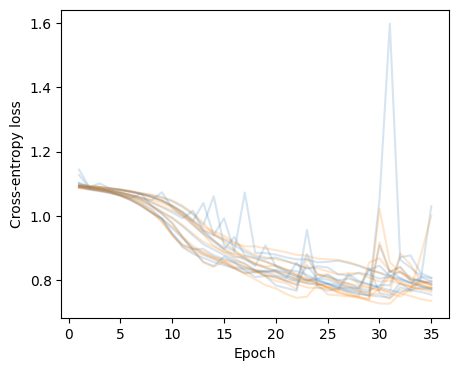

------------------------------ 
Training set:
Average log-likelihood = -5380.8 (485.4)
Average accuracy       = 66.8% (2.4%)
Average F1 score       = 64.2% (4.6%)
------------------------------ 
Validation set:
Average log-likelihood = -797.7 (69.5)
Average accuracy       = 65.1% (1.9%)
Average F1 score       = 62.7% (3.9%)
------------------------------ 
Test set:
Average log-likelihood = -1233.9 (113.5)
Average accuracy       = 76.5% (2.0%)
Average F1 score       = 74.7% (2.2%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


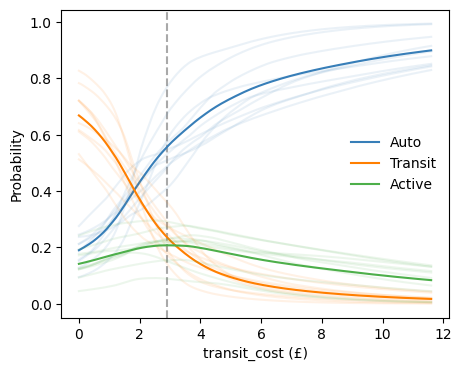

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5039.3 | acc = 69.5% | F1 = 69.2%
Validation set: LL = -747.9  | acc = 68.9% | F1 = 68.5%
Test set:       LL = -1147.3 | acc = 77.3% | F1 = 76.1%
Model 2 
Training set:   LL = -4992.2 | acc = 70.6% | F1 = 70.2%
Validation set: LL = -746.5  | acc = 68.5% | F1 = 68.2%
Test set:       LL = -1126.8 | acc = 78.1% | F1 = 76.5%
Model 3 
Training set:   LL = -5351.6 | acc = 64.2% | F1 = 59.9%
Validation set: LL = -778.5  | acc = 63.0% | F1 = 59.0%
Test set:       LL = -1140.6 | acc = 78.4% | F1 = 76.6%
Model 4 
Training set:   LL = -4969.8 | acc = 70.3% | F1 = 69.4%
Validation set: LL = -747.2  | acc = 67.7% | F1 = 66.8%
Test set:       LL = -1116.7 | acc = 79.7% | F1 = 78.1%
Model 5 
Training set:   LL = -4992.2 | acc = 69.6% | F1 = 68.9%
Validation set: LL = -742.9  | acc = 66.7% | F1 = 65.8%
Test set:       LL = -1087.5 | acc = 79.3% | F1 = 77.6%
Model 6 
Training set:   LL = -4931.9 | acc = 69.8% | F1 = 68.7%
Validat

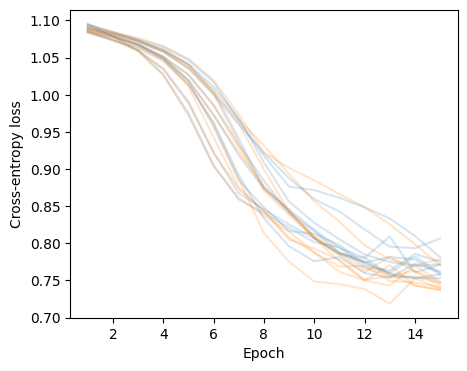

------------------------------ 
Training set:
Average log-likelihood = -5041.7 (130.7)
Average accuracy       = 69.1% (1.9%)
Average F1 score       = 67.9% (3.1%)
------------------------------ 
Validation set:
Average log-likelihood = -748.8 (13.5)
Average accuracy       = 66.8% (1.6%)
Average F1 score       = 65.6% (2.7%)
------------------------------ 
Test set:
Average log-likelihood = -1126.0 (23.6)
Average accuracy       = 78.6% (0.9%)
Average F1 score       = 77.0% (0.9%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.997 (0.004)
Weak regularity   = 0.999 (0.002)
------------------------------


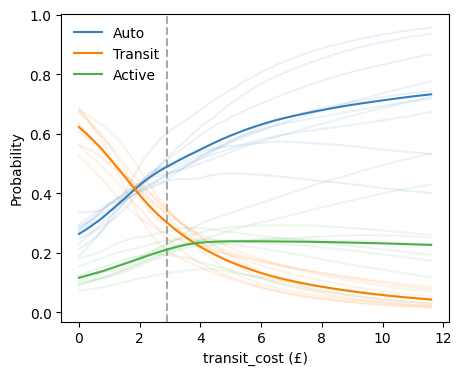

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -4670.8 | acc = 71.9% | F1 = 71.3%
Validation set: LL = -703.7  | acc = 69.0% | F1 = 68.3%
Test set:       LL = -1141.1 | acc = 77.1% | F1 = 76.2%
Model 2 
Training set:   LL = -4672.9 | acc = 71.7% | F1 = 71.1%
Validation set: LL = -709.1  | acc = 68.5% | F1 = 67.9%
Test set:       LL = -1109.4 | acc = 78.6% | F1 = 77.6%
Model 3 
Training set:   LL = -4713.2 | acc = 71.9% | F1 = 71.6%
Validation set: LL = -709.7  | acc = 69.2% | F1 = 68.9%
Test set:       LL = -1064.1 | acc = 79.7% | F1 = 78.5%
Model 4 
Training set:   LL = -4651.2 | acc = 71.6% | F1 = 71.1%
Validation set: LL = -704.0  | acc = 69.4% | F1 = 68.9%
Test set:       LL = -1099.3 | acc = 78.6% | F1 = 77.4%
Model 5 
Training set:   LL = -4653.0 | acc = 71.9% | F1 = 71.2%
Validation set: LL = -703.6  | acc = 69.4% | F1 = 68.8%
Test set:       LL = -1084.4 | acc = 78.5% | F1 = 77.2%
Model 6 
Training set:   LL = -4709.2 | acc = 71.6% | F1 = 71.2%
Valid

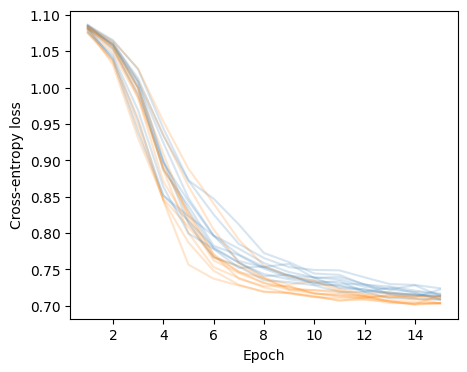

------------------------------ 
Training set:
Average log-likelihood = -4677.2 (26.2)
Average accuracy       = 71.7% (0.2%)
Average F1 score       = 71.2% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -707.6 (4.3)
Average accuracy       = 68.9% (0.6%)
Average F1 score       = 68.4% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1100.3 (33.6)
Average accuracy       = 78.5% (0.8%)
Average F1 score       = 77.5% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.997 (0.005)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.996 (0.004)
Weak regularity   = 0.998 (0.002)
------------------------------ 
Test set:
Strong regularity = 0.978 (0.024)
Weak regularity   = 0.986 (0.017)
------------------------------


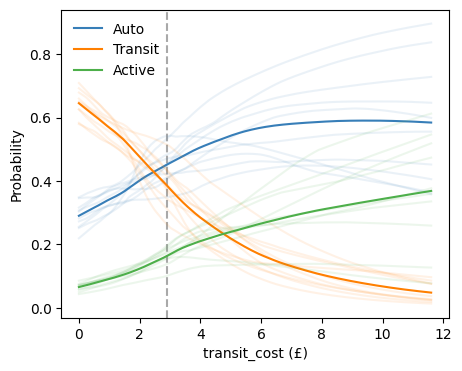

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4541.7 | acc = 72.3% | F1 = 72.1%
Validation set: LL = -693.4  | acc = 69.5% | F1 = 69.2%
Test set:       LL = -1091.8 | acc = 78.2% | F1 = 77.5%
Model 2 
Training set:   LL = -4527.9 | acc = 72.1% | F1 = 71.9%
Validation set: LL = -702.0  | acc = 69.4% | F1 = 69.2%
Test set:       LL = -1176.7 | acc = 76.8% | F1 = 76.5%
Model 3 
Training set:   LL = -4520.7 | acc = 72.6% | F1 = 72.3%
Validation set: LL = -697.7  | acc = 69.1% | F1 = 68.9%
Test set:       LL = -1103.5 | acc = 78.3% | F1 = 77.9%
Model 4 
Training set:   LL = -4527.3 | acc = 72.8% | F1 = 72.5%
Validation set: LL = -694.4  | acc = 70.2% | F1 = 69.9%
Test set:       LL = -1077.3 | acc = 79.5% | F1 = 78.7%
Model 5 
Training set:   LL = -4532.6 | acc = 72.6% | F1 = 72.4%
Validation set: LL = -692.4  | acc = 70.0% | F1 = 69.7%
Test set:       LL = -1094.4 | acc = 78.0% | F1 = 77.3%
Model 6 
Training set:   LL = -4537.3 | acc = 72.5% | F1 = 72.3%
Vali

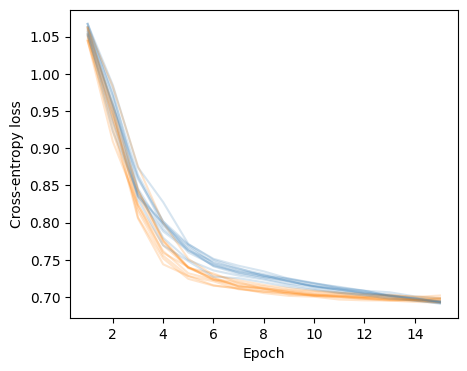

------------------------------ 
Training set:
Average log-likelihood = -4530.7 (6.5)
Average accuracy       = 72.5% (0.2%)
Average F1 score       = 72.2% (0.2%)
------------------------------ 
Validation set:
Average log-likelihood = -696.3 (2.9)
Average accuracy       = 69.4% (0.4%)
Average F1 score       = 69.2% (0.4%)
------------------------------ 
Test set:
Average log-likelihood = -1112.1 (26.7)
Average accuracy       = 78.2% (0.6%)
Average F1 score       = 77.6% (0.6%)
------------------------------ 
Training set:
Strong regularity = 0.991 (0.005)
Weak regularity   = 0.994 (0.002)
------------------------------ 
Validation set:
Strong regularity = 0.990 (0.004)
Weak regularity   = 0.993 (0.003)
------------------------------ 
Test set:
Strong regularity = 0.907 (0.062)
Weak regularity   = 0.925 (0.055)
------------------------------


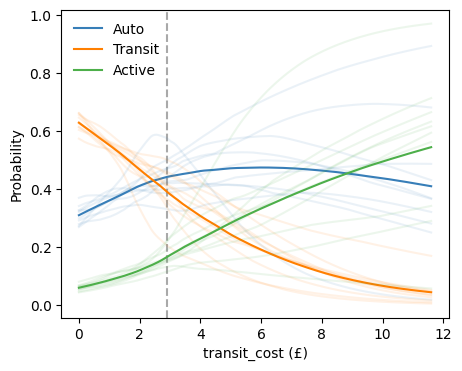

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4529.6 | acc = 72.4% | F1 = 72.1%
Validation set: LL = -695.2  | acc = 69.1% | F1 = 68.8%
Test set:       LL = -1096.5 | acc = 78.0% | F1 = 77.4%
Model 2 
Training set:   LL = -4512.8 | acc = 72.5% | F1 = 72.3%
Validation set: LL = -697.4  | acc = 69.6% | F1 = 69.4%
Test set:       LL = -1143.8 | acc = 77.3% | F1 = 77.2%
Model 3 
Training set:   LL = -4518.1 | acc = 72.5% | F1 = 72.2%
Validation set: LL = -696.0  | acc = 69.0% | F1 = 68.7%
Test set:       LL = -1103.7 | acc = 77.6% | F1 = 77.3%
Model 4 
Training set:   LL = -4525.7 | acc = 72.8% | F1 = 72.5%
Validation set: LL = -695.2  | acc = 70.1% | F1 = 69.8%
Test set:       LL = -1063.7 | acc = 79.2% | F1 = 78.4%
Model 5 
Training set:   LL = -4529.9 | acc = 72.5% | F1 = 72.3%
Validation set: LL = -695.6  | acc = 69.7% | F1 = 69.4%
Test set:       LL = -1089.4 | acc = 78.3% | F1 = 77.7%
Model 6 
Training set:   LL = -4530.5 | acc = 72.6% | F1 = 72.4%
Val

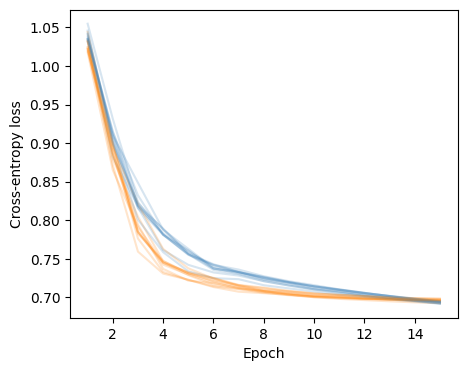

------------------------------ 
Training set:
Average log-likelihood = -4527.2 (6.6)
Average accuracy       = 72.5% (0.1%)
Average F1 score       = 72.3% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -696.2 (1.6)
Average accuracy       = 69.4% (0.3%)
Average F1 score       = 69.1% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1092.8 (21.9)
Average accuracy       = 78.4% (0.6%)
Average F1 score       = 77.9% (0.5%)
------------------------------ 
Training set:
Strong regularity = 0.953 (0.012)
Weak regularity   = 0.958 (0.009)
------------------------------ 
Validation set:
Strong regularity = 0.950 (0.018)
Weak regularity   = 0.955 (0.015)
------------------------------ 
Test set:
Strong regularity = 0.693 (0.132)
Weak regularity   = 0.723 (0.126)
------------------------------


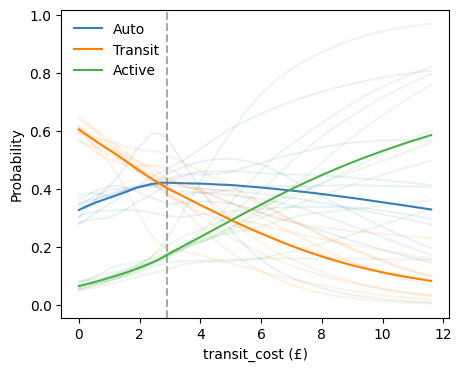

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4546.7 | acc = 72.7% | F1 = 72.4%
Validation set: LL = -698.1  | acc = 68.3% | F1 = 67.9%
Test set:       LL = -1119.3 | acc = 77.6% | F1 = 77.1%
Model 2 
Training set:   LL = -4534.3 | acc = 72.6% | F1 = 72.4%
Validation set: LL = -698.2  | acc = 69.7% | F1 = 69.4%
Test set:       LL = -1118.2 | acc = 78.2% | F1 = 78.0%
Model 3 
Training set:   LL = -4524.5 | acc = 72.8% | F1 = 72.5%
Validation set: LL = -695.5  | acc = 69.2% | F1 = 68.9%
Test set:       LL = -1141.0 | acc = 77.1% | F1 = 76.5%
Model 4 
Training set:   LL = -4527.5 | acc = 72.8% | F1 = 72.5%
Validation set: LL = -694.9  | acc = 69.6% | F1 = 69.3%
Test set:       LL = -1116.9 | acc = 77.5% | F1 = 76.6%
Model 5 
Training set:   LL = -4536.5 | acc = 72.7% | F1 = 72.5%
Validation set: LL = -697.8  | acc = 69.9% | F1 = 69.6%
Test set:       LL = -1103.4 | acc = 78.2% | F1 = 77.3%
Model 6 
Training set:   LL = -4538.1 | acc = 72.7% | F1 = 72.4%
Va

------------------------------ 
Training set:
Average log-likelihood = -4536.8 (7.9)
Average accuracy       = 72.6% (0.1%)
Average F1 score       = 72.4% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -696.9 (2.1)
Average accuracy       = 69.1% (0.5%)
Average F1 score       = 68.8% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1101.0 (23.7)
Average accuracy       = 78.4% (0.8%)
Average F1 score       = 77.7% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.832 (0.033)
Weak regularity   = 0.842 (0.031)
------------------------------ 
Validation set:
Strong regularity = 0.825 (0.035)
Weak regularity   = 0.837 (0.034)
------------------------------ 
Test set:
Strong regularity = 0.323 (0.135)
Weak regularity   = 0.352 (0.143)
------------------------------


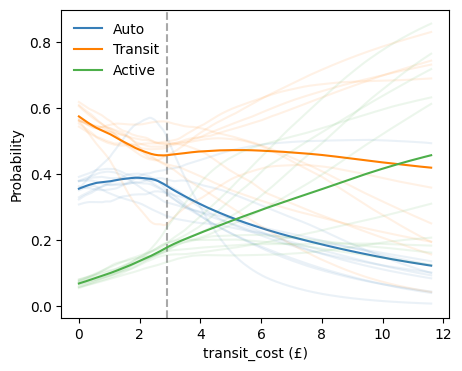

------------------------------ 
Model comparison:


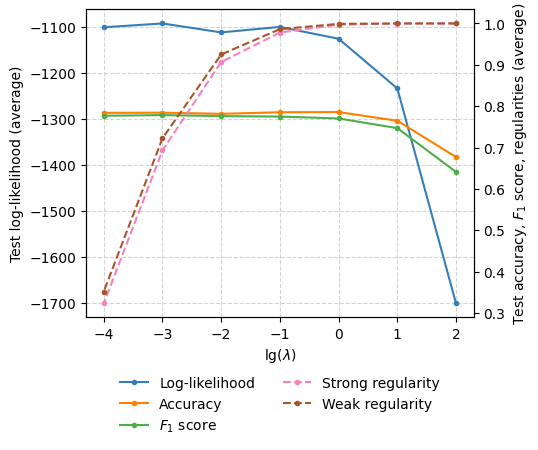

In [ ]:
# With sum
result(DNN, 15, 'LGR', [10**i for i in range(2, -5, -1)])

## TasteNet
A flexible NN-based choice model proposed by [Han et al. (2022)](https://doi.org/10.1016/j.trb.2022.07.001). Here is a special case that learns all $\beta$'s from TasteNet.

In [ ]:
class TasteNet(nn.Module):
    'Class of TasteNet'
    def __init__(self):
        super(TasteNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(7, 100),
            nn.ReLU(),
            nn.Linear(100, 7)
        )

    def forward(self, x):
        'Function to specify utilities using TasteNet parameters'
        betas = self.seq(x[:, :7])
        V1 = betas[:, 0] * torch.ones(len(x)) + torch.sum(betas[:, 1:3] * x[:, 7:9], dim=1)
        V2 = betas[:, 3] * torch.ones(len(x)) + torch.sum(betas[:, 4:6] * x[:, 9:11], dim=1)
        V3 = betas[:, 6] * x[:, 11]
        return torch.stack((V1, V2, V3), dim=1)

### Without GR

Penalty = 0
------------------------------
Model 1 
Training set:   LL = -4655.6 | acc = 72.2% | F1 = 71.8%
Validation set: LL = -720.2  | acc = 69.8% | F1 = 69.4%
Test set:       LL = -1233.6 | acc = 77.3% | F1 = 76.2%
Model 2 
Training set:   LL = -4660.5 | acc = 72.4% | F1 = 72.1%
Validation set: LL = -718.2  | acc = 69.7% | F1 = 69.3%
Test set:       LL = -1178.9 | acc = 78.5% | F1 = 77.4%
Model 3 
Training set:   LL = -4662.0 | acc = 72.3% | F1 = 72.0%
Validation set: LL = -723.9  | acc = 70.2% | F1 = 69.8%
Test set:       LL = -1202.4 | acc = 78.5% | F1 = 77.4%
Model 4 
Training set:   LL = -4663.6 | acc = 72.3% | F1 = 71.9%
Validation set: LL = -718.9  | acc = 69.9% | F1 = 69.5%
Test set:       LL = -1191.8 | acc = 78.0% | F1 = 77.0%
Model 5 
Training set:   LL = -4657.6 | acc = 72.5% | F1 = 72.1%
Validation set: LL = -723.1  | acc = 69.9% | F1 = 69.5%
Test set:       LL = -1298.1 | acc = 75.2% | F1 = 74.4%
Model 6 
Training set:   LL = -4663.8 | acc = 72.4% | F1 = 72.1%
Validat

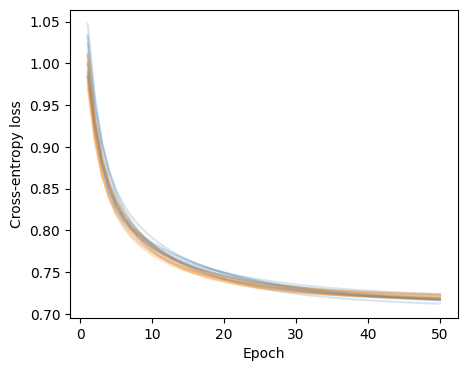

------------------------------ 
Training set:
Average log-likelihood = -4661.6 (8.0)
Average accuracy       = 72.4% (0.1%)
Average F1 score       = 72.0% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -720.3 (2.2)
Average accuracy       = 70.1% (0.3%)
Average F1 score       = 69.7% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1221.1 (33.1)
Average accuracy       = 77.6% (0.9%)
Average F1 score       = 76.5% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.645 (0.070)
Weak regularity   = 0.676 (0.067)
------------------------------ 
Validation set:
Strong regularity = 0.637 (0.070)
Weak regularity   = 0.668 (0.066)
------------------------------ 
Test set:
Strong regularity = 0.313 (0.007)
Weak regularity   = 0.343 (0.008)
------------------------------


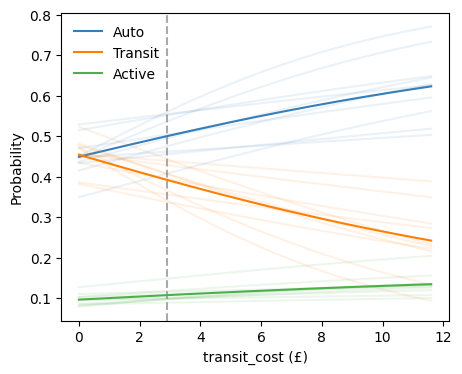

In [ ]:
result(TasteNet, 50, 'none')

### PGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -6652.7 | acc = 57.5% | F1 = 54.0%
Validation set: LL = -971.0  | acc = 55.4% | F1 = 51.3%
Test set:       LL = -2058.0 | acc = 49.4% | F1 = 42.9%
Model 2 
Training set:   LL = -6543.0 | acc = 59.1% | F1 = 53.7%
Validation set: LL = -953.2  | acc = 58.1% | F1 = 52.6%
Test set:       LL = -1872.7 | acc = 59.2% | F1 = 59.7%
Model 3 
Training set:   LL = -7880.3 | acc = 33.9% | F1 = 23.9%
Validation set: LL = -1139.9 | acc = 34.8% | F1 = 24.0%
Test set:       LL = -2182.0 | acc = 35.9% | F1 = 44.5%
Model 4 
Training set:   LL = -7217.6 | acc = 47.3% | F1 = 35.5%
Validation set: LL = -1045.8 | acc = 46.9% | F1 = 34.6%
Test set:       LL = -2387.8 | acc = 48.9% | F1 = 38.1%
Model 5 
Training set:   LL = -6465.7 | acc = 59.9% | F1 = 53.6%
Validation set: LL = -932.6  | acc = 59.4% | F1 = 52.7%
Test set:       LL = -1999.1 | acc = 55.1% | F1 = 52.5%
Model 6 
Training set:   LL = -7761.9 | acc = 45.6% | F1 = 32.6%
Valida

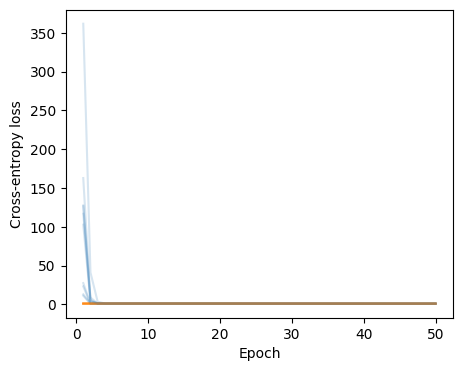

------------------------------ 
Training set:
Average log-likelihood = -7267.2 (543.6)
Average accuracy       = 46.6% (9.3%)
Average F1 score       = 39.7% (10.5%)
------------------------------ 
Validation set:
Average log-likelihood = -1050.9 (77.1)
Average accuracy       = 46.4% (8.7%)
Average F1 score       = 39.3% (9.8%)
------------------------------ 
Test set:
Average log-likelihood = -2218.7 (200.6)
Average accuracy       = 44.7% (10.8%)
Average F1 score       = 41.9% (8.8%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


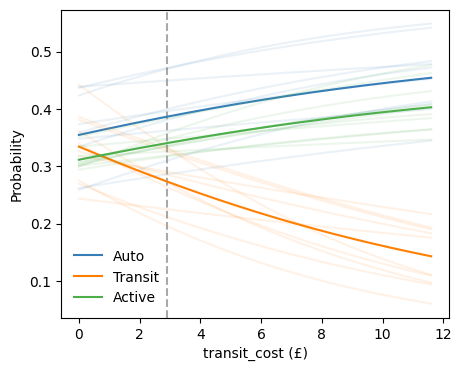

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5865.7 | acc = 62.2% | F1 = 57.9%
Validation set: LL = -865.9  | acc = 60.6% | F1 = 56.1%
Test set:       LL = -1464.5 | acc = 71.4% | F1 = 70.4%
Model 2 
Training set:   LL = -5726.7 | acc = 63.1% | F1 = 59.2%
Validation set: LL = -839.8  | acc = 63.4% | F1 = 59.6%
Test set:       LL = -1317.7 | acc = 76.1% | F1 = 75.0%
Model 3 
Training set:   LL = -6292.5 | acc = 61.9% | F1 = 57.1%
Validation set: LL = -918.0  | acc = 60.4% | F1 = 55.9%
Test set:       LL = -1749.9 | acc = 63.1% | F1 = 64.1%
Model 4 
Training set:   LL = -6121.8 | acc = 62.3% | F1 = 59.0%
Validation set: LL = -895.1  | acc = 61.4% | F1 = 58.2%
Test set:       LL = -1569.1 | acc = 69.7% | F1 = 69.2%
Model 5 
Training set:   LL = -5845.0 | acc = 64.0% | F1 = 60.5%
Validation set: LL = -855.1  | acc = 62.2% | F1 = 57.9%
Test set:       LL = -1421.7 | acc = 72.0% | F1 = 71.1%
Model 6 
Training set:   LL = -6291.0 | acc = 60.1% | F1 = 57.1%
Validat

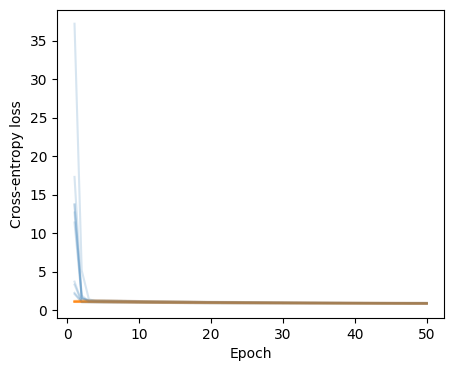

------------------------------ 
Training set:
Average log-likelihood = -6064.3 (238.0)
Average accuracy       = 61.7% (2.1%)
Average F1 score       = 58.1% (1.6%)
------------------------------ 
Validation set:
Average log-likelihood = -885.6 (35.0)
Average accuracy       = 60.6% (2.2%)
Average F1 score       = 57.1% (1.5%)
------------------------------ 
Test set:
Average log-likelihood = -1601.2 (196.7)
Average accuracy       = 67.0% (7.2%)
Average F1 score       = 66.0% (7.7%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------


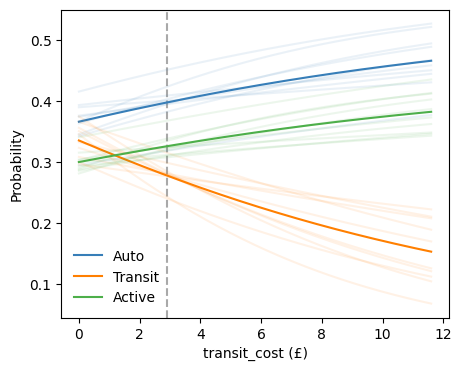

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5177.5 | acc = 68.6% | F1 = 67.4%
Validation set: LL = -769.4  | acc = 66.7% | F1 = 65.2%
Test set:       LL = -1181.2 | acc = 77.5% | F1 = 75.9%
Model 2 
Training set:   LL = -5087.1 | acc = 69.1% | F1 = 68.1%
Validation set: LL = -755.9  | acc = 66.5% | F1 = 65.3%
Test set:       LL = -1163.6 | acc = 78.4% | F1 = 77.0%
Model 3 
Training set:   LL = -5444.2 | acc = 68.2% | F1 = 66.7%
Validation set: LL = -806.7  | acc = 65.8% | F1 = 64.2%
Test set:       LL = -1239.3 | acc = 76.5% | F1 = 75.0%
Model 4 
Training set:   LL = -5367.5 | acc = 67.4% | F1 = 66.0%
Validation set: LL = -790.5  | acc = 65.5% | F1 = 63.8%
Test set:       LL = -1181.5 | acc = 76.9% | F1 = 75.2%
Model 5 
Training set:   LL = -5238.4 | acc = 68.2% | F1 = 66.8%
Validation set: LL = -778.6  | acc = 66.8% | F1 = 65.2%
Test set:       LL = -1181.3 | acc = 77.6% | F1 = 76.0%
Model 6 
Training set:   LL = -5316.7 | acc = 68.3% | F1 = 66.8%
Valid

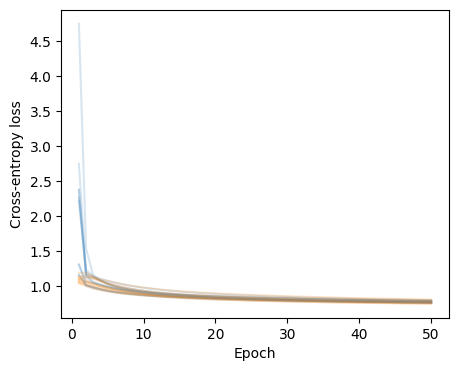

------------------------------ 
Training set:
Average log-likelihood = -5256.9 (126.3)
Average accuracy       = 68.2% (0.7%)
Average F1 score       = 66.9% (1.0%)
------------------------------ 
Validation set:
Average log-likelihood = -778.9 (18.9)
Average accuracy       = 66.1% (0.7%)
Average F1 score       = 64.6% (1.0%)
------------------------------ 
Test set:
Average log-likelihood = -1195.9 (30.9)
Average accuracy       = 77.3% (0.7%)
Average F1 score       = 75.7% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.986 (0.016)
Weak regularity   = 0.998 (0.003)
------------------------------


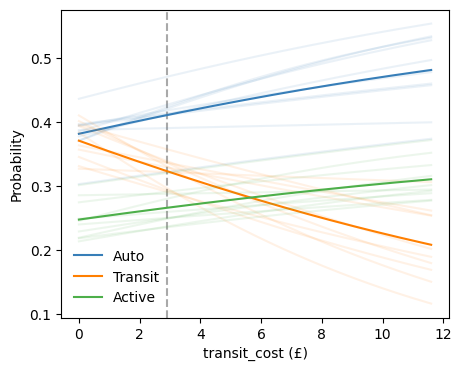

Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4752.3 | acc = 71.6% | F1 = 71.1%
Validation set: LL = -725.3  | acc = 68.3% | F1 = 67.7%
Test set:       LL = -1194.8 | acc = 77.8% | F1 = 76.5%
Model 2 
Training set:   LL = -4741.8 | acc = 71.7% | F1 = 71.2%
Validation set: LL = -721.0  | acc = 68.8% | F1 = 68.2%
Test set:       LL = -1154.8 | acc = 79.1% | F1 = 77.7%
Model 3 
Training set:   LL = -4874.2 | acc = 70.1% | F1 = 69.3%
Validation set: LL = -736.6  | acc = 67.0% | F1 = 66.0%
Test set:       LL = -1153.6 | acc = 78.6% | F1 = 77.2%
Model 4 
Training set:   LL = -4818.4 | acc = 70.9% | F1 = 70.2%
Validation set: LL = -727.0  | acc = 69.4% | F1 = 68.7%
Test set:       LL = -1139.7 | acc = 79.5% | F1 = 78.0%
Model 5 
Training set:   LL = -4756.5 | acc = 71.2% | F1 = 70.6%
Validation set: LL = -728.4  | acc = 67.7% | F1 = 67.0%
Test set:       LL = -1225.6 | acc = 76.8% | F1 = 75.6%
Model 6 
Training set:   LL = -4803.2 | acc = 71.1% | F1 = 70.5%
Vali

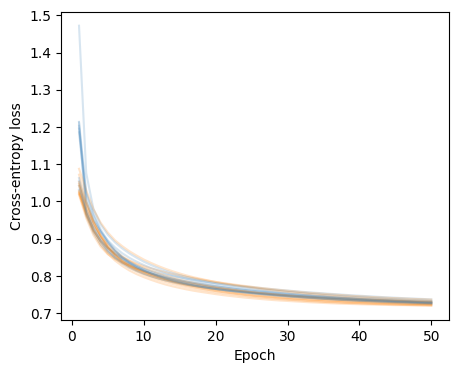

------------------------------ 
Training set:
Average log-likelihood = -4785.8 (41.2)
Average accuracy       = 71.2% (0.5%)
Average F1 score       = 70.6% (0.6%)
------------------------------ 
Validation set:
Average log-likelihood = -726.6 (5.0)
Average accuracy       = 68.6% (0.8%)
Average F1 score       = 68.0% (0.9%)
------------------------------ 
Test set:
Average log-likelihood = -1170.2 (27.0)
Average accuracy       = 78.6% (0.8%)
Average F1 score       = 77.2% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.991 (0.008)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.992 (0.009)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.878 (0.095)
Weak regularity   = 0.993 (0.010)
------------------------------


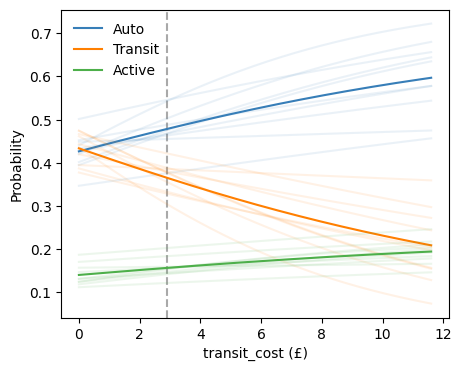

Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4668.1 | acc = 72.1% | F1 = 71.7%
Validation set: LL = -720.7  | acc = 70.3% | F1 = 69.9%
Test set:       LL = -1190.9 | acc = 77.8% | F1 = 76.6%
Model 2 
Training set:   LL = -4672.6 | acc = 72.3% | F1 = 71.9%
Validation set: LL = -717.8  | acc = 69.8% | F1 = 69.5%
Test set:       LL = -1149.0 | acc = 78.9% | F1 = 77.7%
Model 3 
Training set:   LL = -4684.8 | acc = 72.1% | F1 = 71.7%
Validation set: LL = -724.6  | acc = 69.5% | F1 = 69.1%
Test set:       LL = -1169.0 | acc = 78.2% | F1 = 77.2%
Model 4 
Training set:   LL = -4679.2 | acc = 72.1% | F1 = 71.7%
Validation set: LL = -720.3  | acc = 69.7% | F1 = 69.3%
Test set:       LL = -1158.5 | acc = 79.2% | F1 = 78.1%
Model 5 
Training set:   LL = -4667.5 | acc = 72.3% | F1 = 71.9%
Validation set: LL = -723.1  | acc = 69.8% | F1 = 69.4%
Test set:       LL = -1250.8 | acc = 76.8% | F1 = 75.8%
Model 6 
Training set:   LL = -4682.7 | acc = 72.0% | F1 = 71.6%
Val

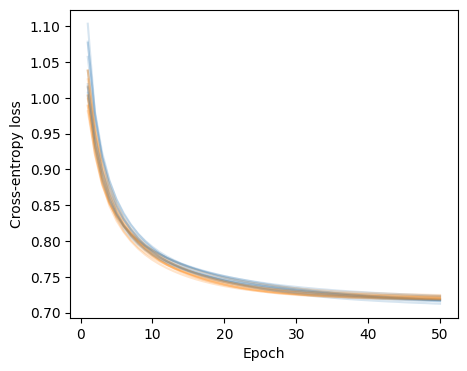

------------------------------ 
Training set:
Average log-likelihood = -4675.6 (8.4)
Average accuracy       = 72.1% (0.1%)
Average F1 score       = 71.7% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -720.6 (2.2)
Average accuracy       = 69.9% (0.3%)
Average F1 score       = 69.5% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1178.9 (30.5)
Average accuracy       = 78.2% (0.7%)
Average F1 score       = 77.2% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.973 (0.023)
Weak regularity   = 0.992 (0.004)
------------------------------ 
Validation set:
Strong regularity = 0.973 (0.024)
Weak regularity   = 0.992 (0.005)
------------------------------ 
Test set:
Strong regularity = 0.727 (0.091)
Weak regularity   = 0.904 (0.054)
------------------------------


Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4656.1 | acc = 72.1% | F1 = 71.7%
Validation set: LL = -720.3  | acc = 70.2% | F1 = 69.8%
Test set:       LL = -1211.7 | acc = 77.7% | F1 = 76.6%
Model 2 
Training set:   LL = -4661.4 | acc = 72.3% | F1 = 71.9%
Validation set: LL = -717.6  | acc = 70.2% | F1 = 69.9%
Test set:       LL = -1160.5 | acc = 78.6% | F1 = 77.5%
Model 3 
Training set:   LL = -4662.7 | acc = 72.2% | F1 = 71.9%
Validation set: LL = -723.6  | acc = 70.0% | F1 = 69.6%
Test set:       LL = -1176.3 | acc = 78.4% | F1 = 77.3%
Model 4 
Training set:   LL = -4662.9 | acc = 72.2% | F1 = 71.9%
Validation set: LL = -719.0  | acc = 70.1% | F1 = 69.7%
Test set:       LL = -1173.4 | acc = 78.3% | F1 = 77.3%
Model 5 
Training set:   LL = -4657.1 | acc = 72.3% | F1 = 72.0%
Validation set: LL = -722.9  | acc = 69.9% | F1 = 69.5%
Test set:       LL = -1280.6 | acc = 76.0% | F1 = 75.2%
Model 6 
Training set:   LL = -4663.9 | acc = 72.2% | F1 = 71.9%
Va

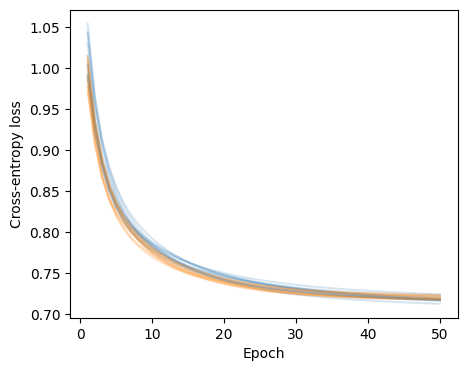

------------------------------ 
Training set:
Average log-likelihood = -4661.3 (7.5)
Average accuracy       = 72.3% (0.1%)
Average F1 score       = 71.9% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -720.1 (2.1)
Average accuracy       = 70.1% (0.2%)
Average F1 score       = 69.7% (0.2%)
------------------------------ 
Test set:
Average log-likelihood = -1200.1 (34.0)
Average accuracy       = 77.7% (0.8%)
Average F1 score       = 76.7% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.852 (0.029)
Weak regularity   = 0.890 (0.012)
------------------------------ 
Validation set:
Strong regularity = 0.849 (0.030)
Weak regularity   = 0.889 (0.013)
------------------------------ 
Test set:
Strong regularity = 0.329 (0.006)
Weak regularity   = 0.386 (0.055)
------------------------------


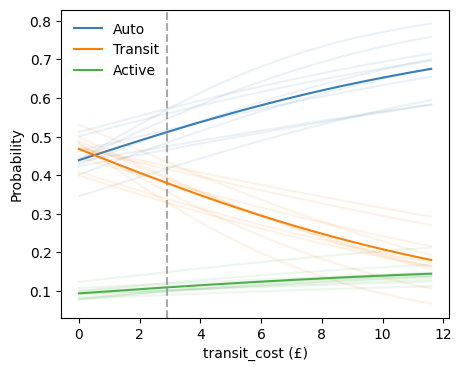

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4655.2 | acc = 72.2% | F1 = 71.9%
Validation set: LL = -720.1  | acc = 69.7% | F1 = 69.3%
Test set:       LL = -1228.8 | acc = 77.3% | F1 = 76.3%
Model 2 
Training set:   LL = -4660.1 | acc = 72.4% | F1 = 72.0%
Validation set: LL = -718.0  | acc = 69.8% | F1 = 69.4%
Test set:       LL = -1175.8 | acc = 78.6% | F1 = 77.5%
Model 3 
Training set:   LL = -4661.6 | acc = 72.4% | F1 = 72.0%
Validation set: LL = -723.7  | acc = 70.2% | F1 = 69.8%
Test set:       LL = -1197.5 | acc = 78.4% | F1 = 77.3%
Model 4 
Training set:   LL = -4663.0 | acc = 72.2% | F1 = 71.8%
Validation set: LL = -718.8  | acc = 70.1% | F1 = 69.7%
Test set:       LL = -1189.9 | acc = 78.0% | F1 = 77.0%
Model 5 
Training set:   LL = -4657.3 | acc = 72.5% | F1 = 72.1%
Validation set: LL = -723.0  | acc = 70.0% | F1 = 69.6%
Test set:       LL = -1294.6 | acc = 75.3% | F1 = 74.6%
Model 6 
Training set:   LL = -4663.3 | acc = 72.5% | F1 = 72.1%
Val

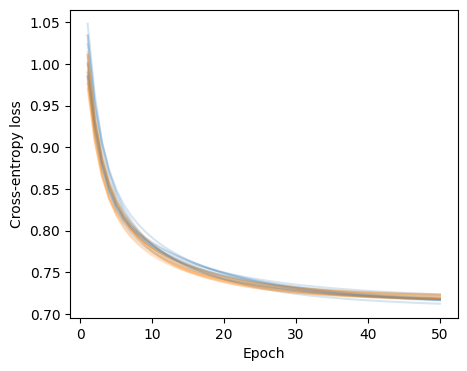

------------------------------ 
Training set:
Average log-likelihood = -4661.1 (7.8)
Average accuracy       = 72.4% (0.1%)
Average F1 score       = 72.0% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -720.2 (2.2)
Average accuracy       = 70.1% (0.3%)
Average F1 score       = 69.7% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1217.4 (33.1)
Average accuracy       = 77.6% (0.9%)
Average F1 score       = 76.6% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.684 (0.061)
Weak regularity   = 0.714 (0.062)
------------------------------ 
Validation set:
Strong regularity = 0.676 (0.060)
Weak regularity   = 0.707 (0.061)
------------------------------ 
Test set:
Strong regularity = 0.317 (0.007)
Weak regularity   = 0.347 (0.008)
------------------------------


------------------------------ 
Model comparison:


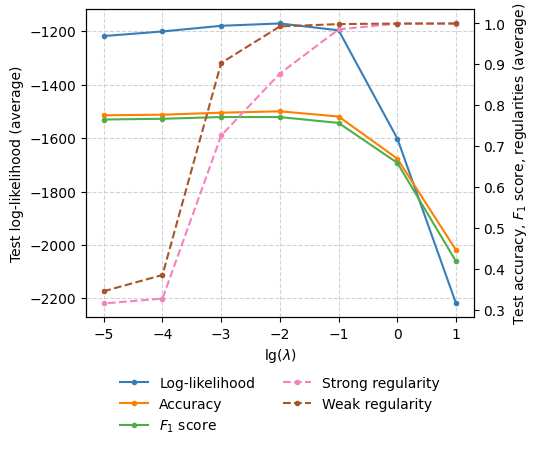

In [ ]:
result(TasteNet, 50, 'PGR', [10**i for i in range(1, -6, -1)])

### UGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -5943.2 | acc = 61.5% | F1 = 57.3%
Validation set: LL = -872.3  | acc = 60.9% | F1 = 56.4%
Test set:       LL = -1404.9 | acc = 72.0% | F1 = 70.8%
Model 2 
Training set:   LL = -5925.8 | acc = 60.7% | F1 = 55.8%
Validation set: LL = -868.2  | acc = 60.6% | F1 = 55.6%
Test set:       LL = -1405.8 | acc = 73.1% | F1 = 72.2%
Model 3 
Training set:   LL = -6065.5 | acc = 59.4% | F1 = 53.8%
Validation set: LL = -884.1  | acc = 59.4% | F1 = 54.0%
Test set:       LL = -1520.2 | acc = 67.7% | F1 = 66.3%
Model 4 
Training set:   LL = -5888.5 | acc = 62.0% | F1 = 58.2%
Validation set: LL = -863.5  | acc = 61.8% | F1 = 58.1%
Test set:       LL = -1334.4 | acc = 73.0% | F1 = 71.7%
Model 5 
Training set:   LL = -5963.7 | acc = 61.8% | F1 = 57.9%
Validation set: LL = -869.8  | acc = 60.7% | F1 = 56.5%
Test set:       LL = -1427.2 | acc = 71.7% | F1 = 70.1%
Model 6 
Training set:   LL = -6005.0 | acc = 59.7% | F1 = 54.8%
Valida

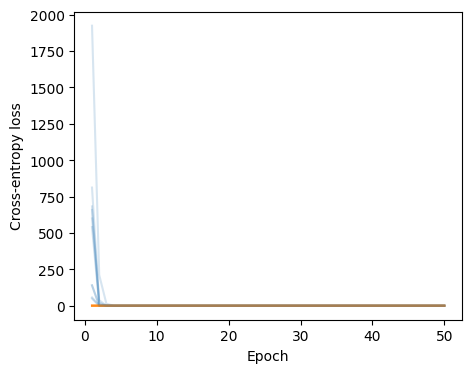

------------------------------ 
Training set:
Average log-likelihood = -5978.4 (49.2)
Average accuracy       = 60.7% (0.9%)
Average F1 score       = 56.1% (1.3%)
------------------------------ 
Validation set:
Average log-likelihood = -873.5 (6.8)
Average accuracy       = 60.3% (0.7%)
Average F1 score       = 55.6% (1.2%)
------------------------------ 
Test set:
Average log-likelihood = -1457.8 (66.9)
Average accuracy       = 70.0% (2.4%)
Average F1 score       = 68.5% (2.6%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


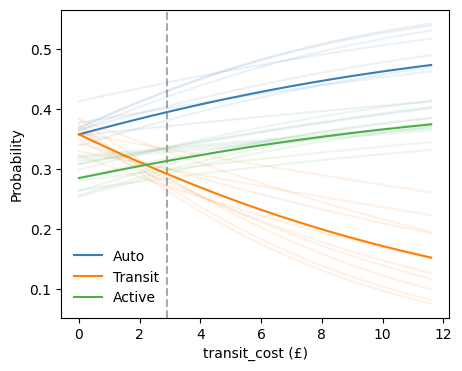

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5881.7 | acc = 62.1% | F1 = 57.9%
Validation set: LL = -864.4  | acc = 61.1% | F1 = 56.7%
Test set:       LL = -1344.1 | acc = 73.5% | F1 = 72.2%
Model 2 
Training set:   LL = -5785.8 | acc = 62.5% | F1 = 58.5%
Validation set: LL = -846.5  | acc = 62.6% | F1 = 58.6%
Test set:       LL = -1307.5 | acc = 75.0% | F1 = 73.5%
Model 3 
Training set:   LL = -6029.8 | acc = 60.4% | F1 = 55.2%
Validation set: LL = -879.0  | acc = 60.0% | F1 = 55.3%
Test set:       LL = -1500.9 | acc = 68.2% | F1 = 66.8%
Model 4 
Training set:   LL = -5846.0 | acc = 62.5% | F1 = 58.7%
Validation set: LL = -857.5  | acc = 62.6% | F1 = 58.9%
Test set:       LL = -1317.1 | acc = 73.5% | F1 = 72.1%
Model 5 
Training set:   LL = -5904.8 | acc = 62.7% | F1 = 59.1%
Validation set: LL = -862.8  | acc = 61.5% | F1 = 57.7%
Test set:       LL = -1390.2 | acc = 72.2% | F1 = 70.6%
Model 6 
Training set:   LL = -5964.4 | acc = 60.3% | F1 = 55.5%
Validat

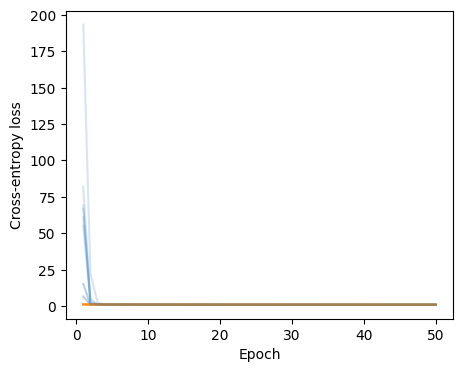

------------------------------ 
Training set:
Average log-likelihood = -5914.2 (68.0)
Average accuracy       = 61.5% (1.0%)
Average F1 score       = 57.1% (1.4%)
------------------------------ 
Validation set:
Average log-likelihood = -864.4 (10.0)
Average accuracy       = 61.0% (1.0%)
Average F1 score       = 56.6% (1.4%)
------------------------------ 
Test set:
Average log-likelihood = -1417.4 (78.8)
Average accuracy       = 71.0% (2.7%)
Average F1 score       = 69.3% (2.9%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


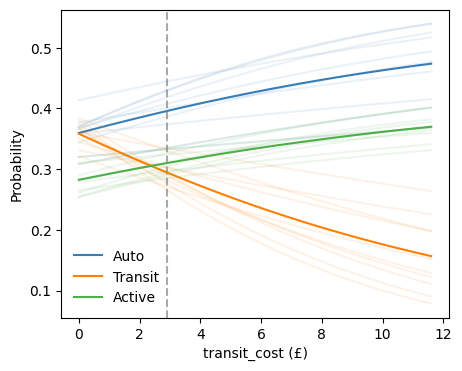

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5561.7 | acc = 65.6% | F1 = 63.0%
Validation set: LL = -820.0  | acc = 64.9% | F1 = 62.3%
Test set:       LL = -1217.3 | acc = 75.7% | F1 = 74.1%
Model 2 
Training set:   LL = -5397.5 | acc = 66.5% | F1 = 64.6%
Validation set: LL = -792.8  | acc = 64.9% | F1 = 62.8%
Test set:       LL = -1190.6 | acc = 78.1% | F1 = 76.4%
Model 3 
Training set:   LL = -5744.0 | acc = 65.9% | F1 = 63.6%
Validation set: LL = -843.4  | acc = 64.0% | F1 = 61.4%
Test set:       LL = -1349.8 | acc = 72.9% | F1 = 71.4%
Model 4 
Training set:   LL = -5650.0 | acc = 64.3% | F1 = 61.2%
Validation set: LL = -829.8  | acc = 63.6% | F1 = 60.2%
Test set:       LL = -1243.9 | acc = 75.5% | F1 = 73.7%
Model 5 
Training set:   LL = -5605.7 | acc = 65.7% | F1 = 63.4%
Validation set: LL = -824.0  | acc = 63.3% | F1 = 60.4%
Test set:       LL = -1251.2 | acc = 75.2% | F1 = 73.6%
Model 6 
Training set:   LL = -5700.9 | acc = 63.9% | F1 = 60.6%
Valid

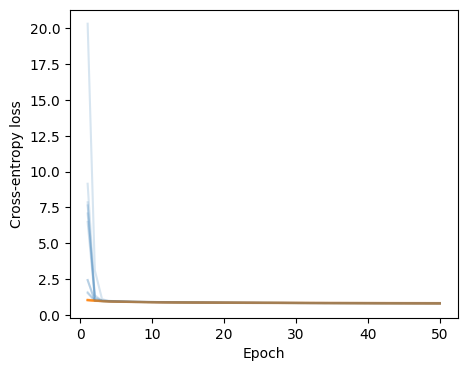

------------------------------ 
Training set:
Average log-likelihood = -5601.5 (111.1)
Average accuracy       = 65.3% (1.3%)
Average F1 score       = 62.7% (1.9%)
------------------------------ 
Validation set:
Average log-likelihood = -822.0 (17.2)
Average accuracy       = 63.9% (0.8%)
Average F1 score       = 61.0% (1.4%)
------------------------------ 
Test set:
Average log-likelihood = -1284.1 (67.6)
Average accuracy       = 74.7% (1.8%)
Average F1 score       = 72.9% (1.9%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.002)
Weak regularity   = 0.999 (0.001)
------------------------------


Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4959.2 | acc = 69.6% | F1 = 68.7%
Validation set: LL = -743.6  | acc = 66.7% | F1 = 65.6%
Test set:       LL = -1187.8 | acc = 77.6% | F1 = 76.0%
Model 2 
Training set:   LL = -4937.3 | acc = 69.7% | F1 = 68.9%
Validation set: LL = -738.9  | acc = 66.7% | F1 = 65.7%
Test set:       LL = -1170.3 | acc = 78.7% | F1 = 77.2%
Model 3 
Training set:   LL = -5217.6 | acc = 68.3% | F1 = 67.2%
Validation set: LL = -775.9  | acc = 65.8% | F1 = 64.4%
Test set:       LL = -1168.8 | acc = 77.2% | F1 = 75.5%
Model 4 
Training set:   LL = -5138.1 | acc = 68.4% | F1 = 67.2%
Validation set: LL = -761.0  | acc = 66.4% | F1 = 65.1%
Test set:       LL = -1147.2 | acc = 77.6% | F1 = 75.9%
Model 5 
Training set:   LL = -5028.4 | acc = 68.9% | F1 = 67.8%
Validation set: LL = -754.7  | acc = 66.9% | F1 = 65.7%
Test set:       LL = -1177.3 | acc = 77.3% | F1 = 75.8%
Model 6 
Training set:   LL = -5082.9 | acc = 68.9% | F1 = 67.8%
Vali

------------------------------ 
Training set:
Average log-likelihood = -5038.7 (98.3)
Average accuracy       = 69.2% (0.6%)
Average F1 score       = 68.2% (0.8%)
------------------------------ 
Validation set:
Average log-likelihood = -751.4 (13.5)
Average accuracy       = 66.6% (0.6%)
Average F1 score       = 65.4% (0.7%)
------------------------------ 
Test set:
Average log-likelihood = -1174.4 (17.3)
Average accuracy       = 77.9% (0.7%)
Average F1 score       = 76.3% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.998 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.997 (0.003)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.954 (0.046)
Weak regularity   = 0.996 (0.004)
------------------------------


Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4704.7 | acc = 72.0% | F1 = 71.6%
Validation set: LL = -722.4  | acc = 69.5% | F1 = 69.0%
Test set:       LL = -1193.6 | acc = 77.8% | F1 = 76.5%
Model 2 
Training set:   LL = -4704.3 | acc = 72.0% | F1 = 71.6%
Validation set: LL = -719.2  | acc = 69.2% | F1 = 68.7%
Test set:       LL = -1151.2 | acc = 79.1% | F1 = 77.8%
Model 3 
Training set:   LL = -4771.3 | acc = 71.2% | F1 = 70.6%
Validation set: LL = -728.7  | acc = 69.0% | F1 = 68.3%
Test set:       LL = -1164.0 | acc = 78.5% | F1 = 77.3%
Model 4 
Training set:   LL = -4742.0 | acc = 71.5% | F1 = 71.0%
Validation set: LL = -722.8  | acc = 69.6% | F1 = 69.0%
Test set:       LL = -1139.9 | acc = 79.2% | F1 = 77.9%
Model 5 
Training set:   LL = -4704.9 | acc = 71.9% | F1 = 71.4%
Validation set: LL = -724.8  | acc = 69.3% | F1 = 68.8%
Test set:       LL = -1238.2 | acc = 76.5% | F1 = 75.5%
Model 6 
Training set:   LL = -4738.9 | acc = 71.6% | F1 = 71.2%
Val

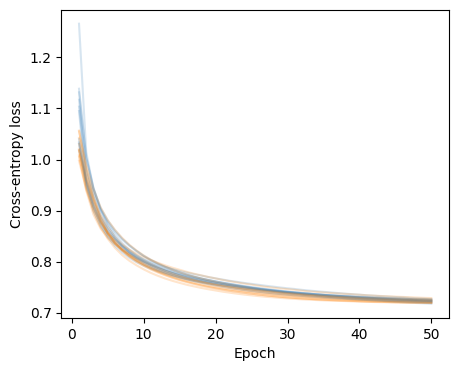

------------------------------ 
Training set:
Average log-likelihood = -4724.6 (21.1)
Average accuracy       = 71.7% (0.3%)
Average F1 score       = 71.3% (0.3%)
------------------------------ 
Validation set:
Average log-likelihood = -722.7 (3.1)
Average accuracy       = 69.4% (0.5%)
Average F1 score       = 68.9% (0.5%)
------------------------------ 
Test set:
Average log-likelihood = -1171.1 (28.5)
Average accuracy       = 78.5% (0.8%)
Average F1 score       = 77.2% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.991 (0.006)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Validation set:
Strong regularity = 0.992 (0.006)
Weak regularity   = 0.999 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.872 (0.095)
Weak regularity   = 0.988 (0.012)
------------------------------


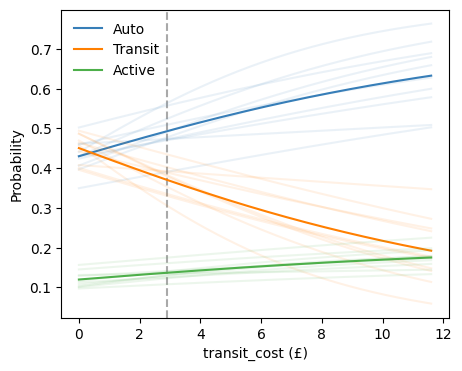

Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4663.4 | acc = 72.0% | F1 = 71.7%
Validation set: LL = -720.7  | acc = 70.3% | F1 = 69.9%
Test set:       LL = -1193.7 | acc = 77.6% | F1 = 76.4%
Model 2 
Training set:   LL = -4667.8 | acc = 72.3% | F1 = 71.9%
Validation set: LL = -717.5  | acc = 70.1% | F1 = 69.8%
Test set:       LL = -1150.3 | acc = 79.0% | F1 = 77.9%
Model 3 
Training set:   LL = -4673.0 | acc = 72.1% | F1 = 71.7%
Validation set: LL = -724.2  | acc = 69.9% | F1 = 69.5%
Test set:       LL = -1166.1 | acc = 78.5% | F1 = 77.5%
Model 4 
Training set:   LL = -4671.9 | acc = 72.1% | F1 = 71.7%
Validation set: LL = -720.1  | acc = 69.5% | F1 = 69.1%
Test set:       LL = -1162.5 | acc = 78.6% | F1 = 77.6%
Model 5 
Training set:   LL = -4662.7 | acc = 72.3% | F1 = 72.0%
Validation set: LL = -722.7  | acc = 69.8% | F1 = 69.4%
Test set:       LL = -1255.2 | acc = 76.3% | F1 = 75.5%
Model 6 
Training set:   LL = -4674.2 | acc = 72.1% | F1 = 71.7%
Va

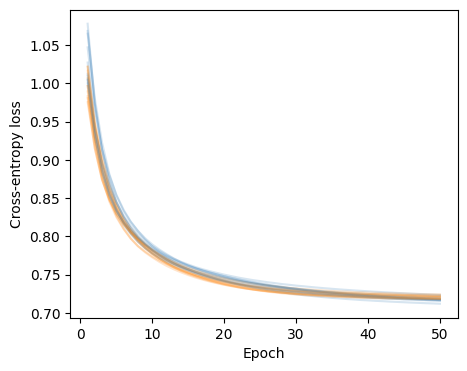

------------------------------ 
Training set:
Average log-likelihood = -4669.0 (7.9)
Average accuracy       = 72.1% (0.1%)
Average F1 score       = 71.7% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -720.4 (2.1)
Average accuracy       = 70.0% (0.3%)
Average F1 score       = 69.6% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1182.0 (31.9)
Average accuracy       = 78.1% (0.8%)
Average F1 score       = 77.1% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.966 (0.011)
Weak regularity   = 0.979 (0.007)
------------------------------ 
Validation set:
Strong regularity = 0.965 (0.014)
Weak regularity   = 0.977 (0.011)
------------------------------ 
Test set:
Strong regularity = 0.652 (0.061)
Weak regularity   = 0.804 (0.084)
------------------------------


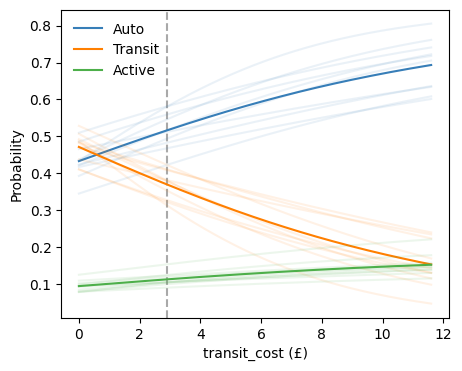

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4655.1 | acc = 72.2% | F1 = 71.8%
Validation set: LL = -720.1  | acc = 70.1% | F1 = 69.7%
Test set:       LL = -1219.2 | acc = 77.7% | F1 = 76.6%
Model 2 
Training set:   LL = -4660.2 | acc = 72.4% | F1 = 72.0%
Validation set: LL = -717.8  | acc = 70.0% | F1 = 69.7%
Test set:       LL = -1167.5 | acc = 78.7% | F1 = 77.6%
Model 3 
Training set:   LL = -4661.5 | acc = 72.2% | F1 = 71.8%
Validation set: LL = -723.7  | acc = 70.0% | F1 = 69.6%
Test set:       LL = -1183.3 | acc = 78.4% | F1 = 77.3%
Model 4 
Training set:   LL = -4662.4 | acc = 72.2% | F1 = 71.9%
Validation set: LL = -719.0  | acc = 70.2% | F1 = 69.8%
Test set:       LL = -1178.6 | acc = 78.0% | F1 = 77.0%
Model 5 
Training set:   LL = -4656.5 | acc = 72.4% | F1 = 72.0%
Validation set: LL = -722.8  | acc = 70.0% | F1 = 69.6%
Test set:       LL = -1283.4 | acc = 75.7% | F1 = 74.9%
Model 6 
Training set:   LL = -4663.4 | acc = 72.3% | F1 = 71.9%
Val

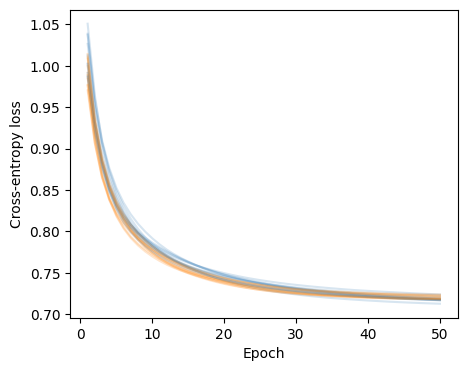

------------------------------ 
Training set:
Average log-likelihood = -4660.7 (7.6)
Average accuracy       = 72.3% (0.1%)
Average F1 score       = 71.9% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -720.1 (2.1)
Average accuracy       = 70.1% (0.2%)
Average F1 score       = 69.8% (0.2%)
------------------------------ 
Test set:
Average log-likelihood = -1205.9 (33.3)
Average accuracy       = 77.7% (0.8%)
Average F1 score       = 76.7% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.818 (0.029)
Weak regularity   = 0.853 (0.022)
------------------------------ 
Validation set:
Strong regularity = 0.812 (0.028)
Weak regularity   = 0.849 (0.024)
------------------------------ 
Test set:
Strong regularity = 0.325 (0.008)
Weak regularity   = 0.356 (0.010)
------------------------------


------------------------------ 
Model comparison:


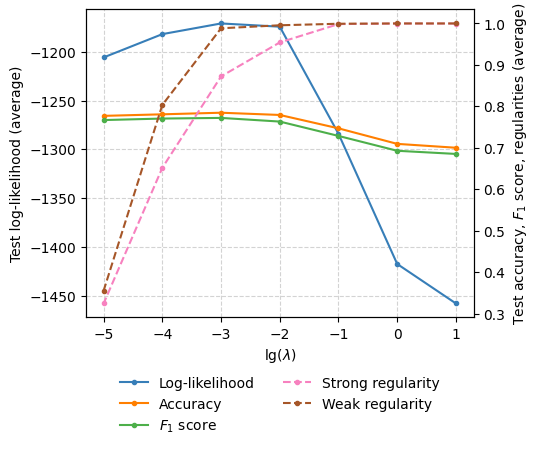

In [ ]:
result(TasteNet, 50, 'UGR', [10**i for i in range(1, -6, -1)])

### LGR

Penalty = 10
------------------------------
Model 1 
Training set:   LL = -6649.4 | acc = 58.3% | F1 = 54.1%
Validation set: LL = -977.8  | acc = 56.3% | F1 = 51.8%
Test set:       LL = -1882.2 | acc = 56.6% | F1 = 52.7%
Model 2 
Training set:   LL = -6470.9 | acc = 58.7% | F1 = 53.2%
Validation set: LL = -944.6  | acc = 57.5% | F1 = 52.8%
Test set:       LL = -1875.2 | acc = 58.0% | F1 = 54.9%
Model 3 
Training set:   LL = -7021.4 | acc = 51.2% | F1 = 42.1%
Validation set: LL = -1012.3 | acc = 52.9% | F1 = 44.2%
Test set:       LL = -2286.9 | acc = 47.7% | F1 = 39.5%
Model 4 
Training set:   LL = -6776.9 | acc = 54.4% | F1 = 47.0%
Validation set: LL = -980.5  | acc = 53.8% | F1 = 45.8%
Test set:       LL = -2044.8 | acc = 53.2% | F1 = 46.7%
Model 5 
Training set:   LL = -6398.3 | acc = 60.0% | F1 = 54.4%
Validation set: LL = -921.1  | acc = 59.3% | F1 = 53.6%
Test set:       LL = -1935.3 | acc = 57.3% | F1 = 55.1%
Model 6 
Training set:   LL = -6981.3 | acc = 53.0% | F1 = 47.9%
Valida

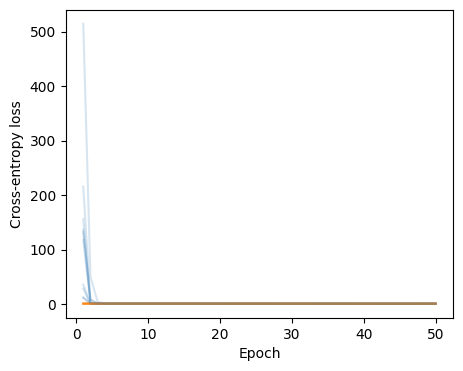

------------------------------ 
Training set:
Average log-likelihood = -6840.2 (266.0)
Average accuracy       = 54.6% (3.5%)
Average F1 score       = 48.3% (4.3%)
------------------------------ 
Validation set:
Average log-likelihood = -990.9 (37.1)
Average accuracy       = 53.6% (3.5%)
Average F1 score       = 47.4% (4.1%)
------------------------------ 
Test set:
Average log-likelihood = -2038.1 (210.9)
Average accuracy       = 55.3% (5.6%)
Average F1 score       = 50.9% (8.0%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------


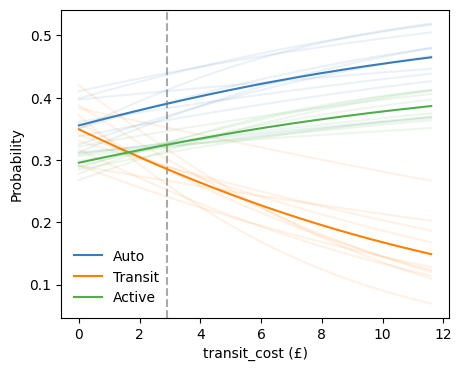

Penalty = 1
------------------------------
Model 1 
Training set:   LL = -5804.1 | acc = 62.8% | F1 = 58.7%
Validation set: LL = -856.9  | acc = 61.1% | F1 = 56.6%
Test set:       LL = -1389.5 | acc = 73.5% | F1 = 72.1%
Model 2 
Training set:   LL = -5678.1 | acc = 64.3% | F1 = 61.4%
Validation set: LL = -831.5  | acc = 63.8% | F1 = 61.0%
Test set:       LL = -1306.0 | acc = 76.4% | F1 = 75.5%
Model 3 
Training set:   LL = -6267.7 | acc = 60.6% | F1 = 53.9%
Validation set: LL = -908.4  | acc = 60.4% | F1 = 53.8%
Test set:       LL = -1757.0 | acc = 64.0% | F1 = 64.6%
Model 4 
Training set:   LL = -6016.8 | acc = 62.1% | F1 = 57.0%
Validation set: LL = -878.5  | acc = 61.7% | F1 = 56.5%
Test set:       LL = -1501.1 | acc = 72.7% | F1 = 72.1%
Model 5 
Training set:   LL = -5792.7 | acc = 64.5% | F1 = 61.1%
Validation set: LL = -847.6  | acc = 61.7% | F1 = 57.5%
Test set:       LL = -1357.8 | acc = 73.5% | F1 = 72.0%
Model 6 
Training set:   LL = -6258.3 | acc = 59.4% | F1 = 54.2%
Validat

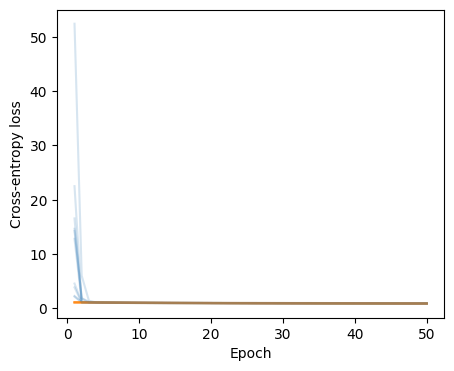

------------------------------ 
Training set:
Average log-likelihood = -5997.0 (223.3)
Average accuracy       = 62.6% (1.8%)
Average F1 score       = 58.3% (3.0%)
------------------------------ 
Validation set:
Average log-likelihood = -874.3 (30.3)
Average accuracy       = 61.5% (1.6%)
Average F1 score       = 57.2% (2.6%)
------------------------------ 
Test set:
Average log-likelihood = -1568.9 (203.3)
Average accuracy       = 68.6% (6.0%)
Average F1 score       = 67.3% (6.5%)
------------------------------ 
Training set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Test set:
Strong regularity = 1.000 (0.000)
Weak regularity   = 1.000 (0.000)
------------------------------


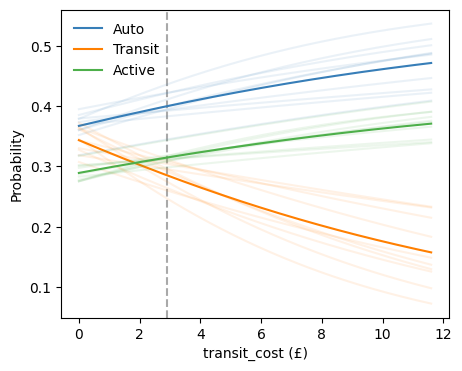

Penalty = 0.1
------------------------------
Model 1 
Training set:   LL = -5136.3 | acc = 68.9% | F1 = 67.7%
Validation set: LL = -762.5  | acc = 66.8% | F1 = 65.5%
Test set:       LL = -1178.2 | acc = 77.8% | F1 = 76.3%
Model 2 
Training set:   LL = -5088.9 | acc = 69.0% | F1 = 68.1%
Validation set: LL = -755.1  | acc = 66.6% | F1 = 65.4%
Test set:       LL = -1175.0 | acc = 78.7% | F1 = 77.3%
Model 3 
Training set:   LL = -5414.6 | acc = 68.0% | F1 = 66.7%
Validation set: LL = -799.7  | acc = 66.0% | F1 = 64.4%
Test set:       LL = -1230.9 | acc = 77.2% | F1 = 75.7%
Model 4 
Training set:   LL = -5342.6 | acc = 67.2% | F1 = 65.7%
Validation set: LL = -786.8  | acc = 66.0% | F1 = 64.3%
Test set:       LL = -1173.4 | acc = 76.7% | F1 = 74.9%
Model 5 
Training set:   LL = -5215.8 | acc = 68.1% | F1 = 66.6%
Validation set: LL = -773.4  | acc = 66.3% | F1 = 64.6%
Test set:       LL = -1189.9 | acc = 77.3% | F1 = 75.7%
Model 6 
Training set:   LL = -5326.9 | acc = 68.0% | F1 = 66.3%
Valid

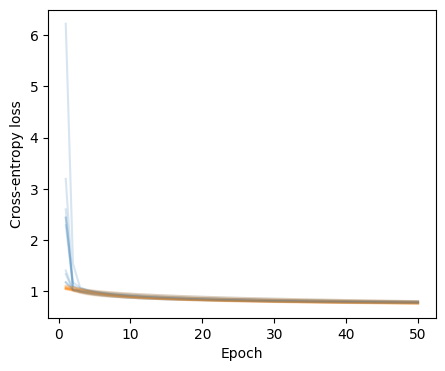

------------------------------ 
Training set:
Average log-likelihood = -5237.3 (121.3)
Average accuracy       = 68.1% (0.8%)
Average F1 score       = 66.8% (1.1%)
------------------------------ 
Validation set:
Average log-likelihood = -774.1 (17.7)
Average accuracy       = 66.2% (0.5%)
Average F1 score       = 64.7% (0.8%)
------------------------------ 
Test set:
Average log-likelihood = -1204.0 (34.7)
Average accuracy       = 77.3% (0.9%)
Average F1 score       = 75.7% (0.9%)
------------------------------ 
Training set:
Strong regularity = 0.999 (0.001)
Weak regularity   = 1.000 (0.000)
------------------------------ 
Validation set:
Strong regularity = 0.998 (0.001)
Weak regularity   = 1.000 (0.001)
------------------------------ 
Test set:
Strong regularity = 0.985 (0.013)
Weak regularity   = 0.997 (0.005)
------------------------------


Penalty = 0.01
------------------------------
Model 1 
Training set:   LL = -4741.7 | acc = 71.7% | F1 = 71.2%
Validation set: LL = -723.7  | acc = 68.9% | F1 = 68.4%
Test set:       LL = -1197.7 | acc = 77.9% | F1 = 76.6%
Model 2 
Training set:   LL = -4743.9 | acc = 71.6% | F1 = 71.1%
Validation set: LL = -721.0  | acc = 69.1% | F1 = 68.5%
Test set:       LL = -1153.1 | acc = 79.4% | F1 = 78.0%
Model 3 
Training set:   LL = -4861.0 | acc = 70.3% | F1 = 69.6%
Validation set: LL = -734.6  | acc = 67.7% | F1 = 66.8%
Test set:       LL = -1158.8 | acc = 78.9% | F1 = 77.5%
Model 4 
Training set:   LL = -4823.5 | acc = 70.8% | F1 = 70.2%
Validation set: LL = -725.9  | acc = 69.3% | F1 = 68.6%
Test set:       LL = -1132.7 | acc = 79.8% | F1 = 78.3%
Model 5 
Training set:   LL = -4750.2 | acc = 71.4% | F1 = 70.8%
Validation set: LL = -728.1  | acc = 68.5% | F1 = 67.9%
Test set:       LL = -1219.6 | acc = 77.1% | F1 = 75.9%
Model 6 
Training set:   LL = -4815.8 | acc = 71.2% | F1 = 70.7%
Vali

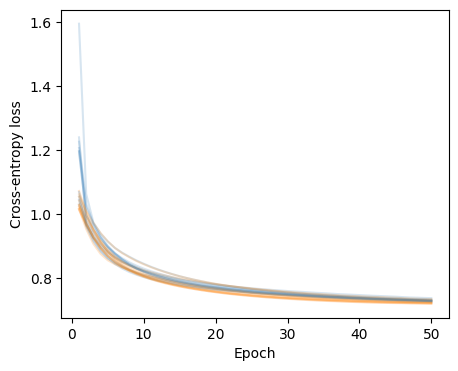

------------------------------ 
Training set:
Average log-likelihood = -4788.7 (39.2)
Average accuracy       = 71.2% (0.5%)
Average F1 score       = 70.6% (0.5%)
------------------------------ 
Validation set:
Average log-likelihood = -726.1 (4.6)
Average accuracy       = 68.8% (0.6%)
Average F1 score       = 68.2% (0.6%)
------------------------------ 
Test set:
Average log-likelihood = -1168.4 (26.3)
Average accuracy       = 78.7% (0.8%)
Average F1 score       = 77.3% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.978 (0.019)
Weak regularity   = 0.997 (0.005)
------------------------------ 
Validation set:
Strong regularity = 0.977 (0.020)
Weak regularity   = 0.996 (0.005)
------------------------------ 
Test set:
Strong regularity = 0.867 (0.071)
Weak regularity   = 0.972 (0.015)
------------------------------


Penalty = 0.001
------------------------------
Model 1 
Training set:   LL = -4667.9 | acc = 72.1% | F1 = 71.7%
Validation set: LL = -720.7  | acc = 70.5% | F1 = 70.1%
Test set:       LL = -1187.3 | acc = 77.8% | F1 = 76.6%
Model 2 
Training set:   LL = -4673.2 | acc = 72.2% | F1 = 71.8%
Validation set: LL = -717.6  | acc = 69.7% | F1 = 69.3%
Test set:       LL = -1148.6 | acc = 79.0% | F1 = 77.8%
Model 3 
Training set:   LL = -4683.7 | acc = 72.1% | F1 = 71.6%
Validation set: LL = -724.5  | acc = 69.7% | F1 = 69.3%
Test set:       LL = -1166.9 | acc = 78.2% | F1 = 77.2%
Model 4 
Training set:   LL = -4679.7 | acc = 72.1% | F1 = 71.7%
Validation set: LL = -720.1  | acc = 69.7% | F1 = 69.3%
Test set:       LL = -1154.1 | acc = 79.1% | F1 = 77.9%
Model 5 
Training set:   LL = -4666.5 | acc = 72.3% | F1 = 71.9%
Validation set: LL = -722.9  | acc = 69.7% | F1 = 69.3%
Test set:       LL = -1252.8 | acc = 76.6% | F1 = 75.7%
Model 6 
Training set:   LL = -4685.3 | acc = 72.0% | F1 = 71.6%
Val

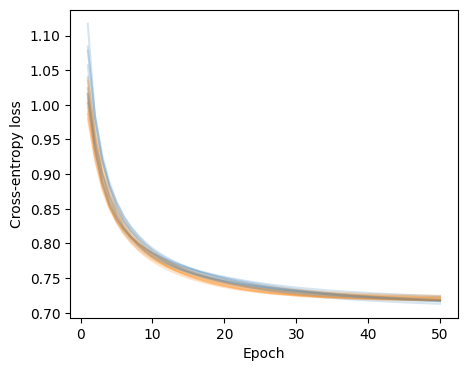

------------------------------ 
Training set:
Average log-likelihood = -4676.5 (8.2)
Average accuracy       = 72.1% (0.1%)
Average F1 score       = 71.7% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -720.4 (2.3)
Average accuracy       = 69.9% (0.3%)
Average F1 score       = 69.5% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1175.0 (30.3)
Average accuracy       = 78.3% (0.7%)
Average F1 score       = 77.2% (0.7%)
------------------------------ 
Training set:
Strong regularity = 0.968 (0.023)
Weak regularity   = 0.989 (0.005)
------------------------------ 
Validation set:
Strong regularity = 0.967 (0.026)
Weak regularity   = 0.988 (0.007)
------------------------------ 
Test set:
Strong regularity = 0.720 (0.083)
Weak regularity   = 0.900 (0.045)
------------------------------


Penalty = 0.0001
------------------------------
Model 1 
Training set:   LL = -4656.4 | acc = 72.1% | F1 = 71.7%
Validation set: LL = -720.3  | acc = 70.1% | F1 = 69.7%
Test set:       LL = -1211.3 | acc = 77.6% | F1 = 76.5%
Model 2 
Training set:   LL = -4661.5 | acc = 72.3% | F1 = 71.9%
Validation set: LL = -717.8  | acc = 70.1% | F1 = 69.8%
Test set:       LL = -1161.3 | acc = 78.6% | F1 = 77.5%
Model 3 
Training set:   LL = -4662.8 | acc = 72.3% | F1 = 71.9%
Validation set: LL = -723.6  | acc = 70.0% | F1 = 69.6%
Test set:       LL = -1176.6 | acc = 78.5% | F1 = 77.3%
Model 4 
Training set:   LL = -4663.1 | acc = 72.3% | F1 = 71.9%
Validation set: LL = -719.1  | acc = 70.2% | F1 = 69.8%
Test set:       LL = -1173.5 | acc = 78.5% | F1 = 77.4%
Model 5 
Training set:   LL = -4657.3 | acc = 72.4% | F1 = 72.0%
Validation set: LL = -722.9  | acc = 69.9% | F1 = 69.5%
Test set:       LL = -1281.7 | acc = 75.8% | F1 = 75.0%
Model 6 
Training set:   LL = -4664.1 | acc = 72.2% | F1 = 71.9%
Va

------------------------------ 
Training set:
Average log-likelihood = -4661.6 (7.4)
Average accuracy       = 72.3% (0.1%)
Average F1 score       = 71.9% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -720.1 (2.1)
Average accuracy       = 70.1% (0.3%)
Average F1 score       = 69.7% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1200.3 (34.3)
Average accuracy       = 77.8% (0.9%)
Average F1 score       = 76.8% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.852 (0.029)
Weak regularity   = 0.890 (0.012)
------------------------------ 
Validation set:
Strong regularity = 0.850 (0.029)
Weak regularity   = 0.889 (0.013)
------------------------------ 
Test set:
Strong regularity = 0.330 (0.007)
Weak regularity   = 0.386 (0.056)
------------------------------


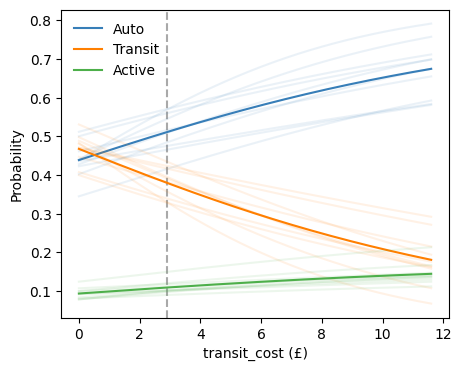

Penalty = 1e-05
------------------------------
Model 1 
Training set:   LL = -4655.3 | acc = 72.2% | F1 = 71.9%
Validation set: LL = -720.1  | acc = 69.7% | F1 = 69.3%
Test set:       LL = -1228.8 | acc = 77.3% | F1 = 76.3%
Model 2 
Training set:   LL = -4660.2 | acc = 72.4% | F1 = 72.0%
Validation set: LL = -718.0  | acc = 69.8% | F1 = 69.4%
Test set:       LL = -1176.0 | acc = 78.6% | F1 = 77.5%
Model 3 
Training set:   LL = -4661.7 | acc = 72.3% | F1 = 72.0%
Validation set: LL = -723.8  | acc = 70.2% | F1 = 69.8%
Test set:       LL = -1197.6 | acc = 78.4% | F1 = 77.3%
Model 4 
Training set:   LL = -4663.2 | acc = 72.2% | F1 = 71.8%
Validation set: LL = -718.8  | acc = 70.1% | F1 = 69.7%
Test set:       LL = -1189.7 | acc = 78.0% | F1 = 76.9%
Model 5 
Training set:   LL = -4657.3 | acc = 72.5% | F1 = 72.1%
Validation set: LL = -723.0  | acc = 70.0% | F1 = 69.6%
Test set:       LL = -1294.8 | acc = 75.3% | F1 = 74.6%
Model 6 
Training set:   LL = -4663.3 | acc = 72.5% | F1 = 72.1%
Val

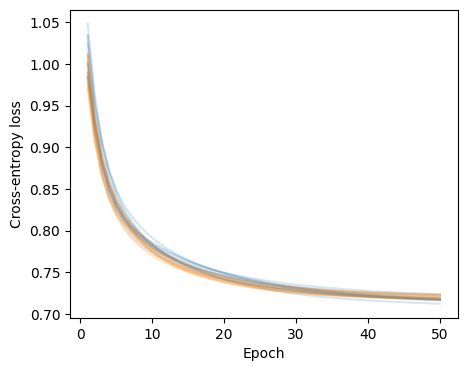

------------------------------ 
Training set:
Average log-likelihood = -4661.2 (7.8)
Average accuracy       = 72.4% (0.1%)
Average F1 score       = 72.0% (0.1%)
------------------------------ 
Validation set:
Average log-likelihood = -720.2 (2.2)
Average accuracy       = 70.1% (0.3%)
Average F1 score       = 69.7% (0.3%)
------------------------------ 
Test set:
Average log-likelihood = -1217.4 (33.1)
Average accuracy       = 77.6% (0.9%)
Average F1 score       = 76.6% (0.8%)
------------------------------ 
Training set:
Strong regularity = 0.683 (0.061)
Weak regularity   = 0.712 (0.063)
------------------------------ 
Validation set:
Strong regularity = 0.676 (0.060)
Weak regularity   = 0.706 (0.062)
------------------------------ 
Test set:
Strong regularity = 0.317 (0.007)
Weak regularity   = 0.347 (0.008)
------------------------------


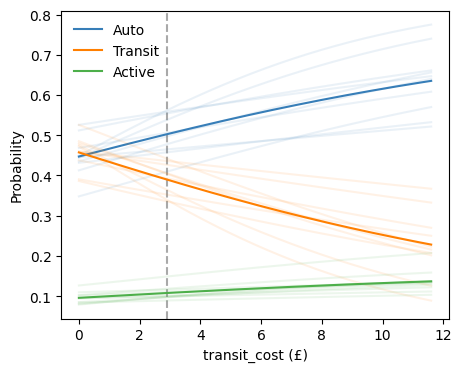

------------------------------ 
Model comparison:


In [ ]:
result(TasteNet, 50, 'LGR', [10**i for i in range(1, -6, -1)])

# Final results

In [ ]:
weights = np.array([2/val_size, .5, .5, 1, 1])
scores = results_val.multiply(weights, axis=0).sum()
l_col = []
for model in ['DNN', 'TasteNet']:
    l_col.append(model)
    for GR in ['PGR', 'UGR', 'LGR']:
        l_col.append(scores[scores.index.str.startswith(f'{model}, sum-{GR}')].idxmax())
l_col.append('MNL')

In [ ]:
results_train = results_train[l_col]
results_val = results_val[l_col].iloc[:5]
results_test = results_test[l_col]

results_train_std = results_train_std[l_col]
results_val_std = results_val_std[l_col]
results_test_std = results_test_std[l_col]

In [ ]:
results_train.to_csv(f'{path}/Regularity_results_L/10K_S_London_train.csv')
results_val.to_csv(f'{path}/Regularity_results_L/10K_S_London_val.csv')
results_test.to_csv(f'{path}/Regularity_results_L/10K_S_London_test.csv')

results_train_std.to_csv(f'{path}/Regularity_results_L/10K_S_London_train_std.csv')
results_val_std.to_csv(f'{path}/Regularity_results_L/10K_S_London_val_std.csv')
results_test_std.to_csv(f'{path}/Regularity_results_L/10K_S_London_test_std.csv')

In [ ]:
results_train.iloc[0] = results_train.iloc[0].round(1)
results_val.iloc[0] = results_val.iloc[0].round(1)
results_test.iloc[0] = results_test.iloc[0].round(1)

In [ ]:
df_train = results_train.round(3).astype(str).add(' (').add(results_train_std.round(3).astype(str)).add(')')
df_val = results_val.round(3).astype(str).add(' (').add(results_val_std.round(3).astype(str)).add(')')
df_test = results_test.round(3).astype(str).add(' (').add(results_test_std.round(3).astype(str)).add(')')

In [ ]:
print(df_train.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.1) & DNN, sum-UGR (10) & DNN, sum-LGR (0.01) & TasteNet & TasteNet, sum-PGR (0.01) & TasteNet, sum-UGR (0.001) & TasteNet, sum-LGR (0.001) & MNL \\
\midrule
Log-likelihood & -4554.5 (11.103) & -4589.4 (25.822) & -4806.0 (71.159) & -4530.7 (6.477) & -4661.6 (7.997) & -4785.8 (41.151) & -4724.6 (21.076) & -4676.5 (8.192) & -4919.2 (0) \\
Accuracy & 0.725 (0.002) & 0.722 (0.002) & 0.71 (0.005) & 0.725 (0.002) & 0.724 (0.001) & 0.712 (0.005) & 0.717 (0.003) & 0.721 (0.001) & 0.712 (0) \\
F1 score & 0.722 (0.002) & 0.719 (0.002) & 0.706 (0.006) & 0.722 (0.002) & 0.72 (0.001) & 0.706 (0.006) & 0.713 (0.003) & 0.717 (0.001) & 0.708 (0) \\
Strong regularity & 0.736 (0.06) & 0.999 (0.001) & 0.991 (0.019) & 0.991 (0.005) & 0.645 (0.07) & 0.991 (0.008) & 0.991 (0.006) & 0.968 (0.023) & 0.997 (0) \\
Weak regularity & 0.751 (0.054) & 0.999 (0.0) & 0.993 (0.016) & 0.994 (0.002) & 0.676 (0.067) & 1.0 (0.0) & 0.999 (0.001) & 0.989 (0.005) &

In [ ]:
print(df_val.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.1) & DNN, sum-UGR (10) & DNN, sum-LGR (0.01) & TasteNet & TasteNet, sum-PGR (0.01) & TasteNet, sum-UGR (0.001) & TasteNet, sum-LGR (0.001) & MNL \\
\midrule
Log-likelihood & -698.5 (2.201) & -699.7 (2.208) & -713.6 (4.791) & -696.3 (2.877) & -720.3 (2.16) & -726.6 (4.988) & -722.7 (3.051) & -720.4 (2.274) & -730.2 (0) \\
Accuracy & 0.691 (0.004) & 0.693 (0.005) & 0.691 (0.004) & 0.694 (0.004) & 0.701 (0.003) & 0.686 (0.008) & 0.694 (0.005) & 0.699 (0.003) & 0.687 (0) \\
F1 score & 0.688 (0.004) & 0.69 (0.005) & 0.688 (0.004) & 0.692 (0.004) & 0.697 (0.003) & 0.68 (0.009) & 0.689 (0.005) & 0.695 (0.003) & 0.683 (0) \\
Strong regularity & 0.724 (0.062) & 0.998 (0.001) & 0.991 (0.02) & 0.99 (0.004) & 0.637 (0.07) & 0.992 (0.009) & 0.992 (0.006) & 0.967 (0.026) & 0.996 (0) \\
Weak regularity & 0.739 (0.054) & 0.999 (0.001) & 0.992 (0.018) & 0.992 (0.003) & 0.668 (0.066) & 1.0 (0.001) & 0.999 (0.001) & 0.988 (0.007) & 1.0 (0) \\


In [ ]:
print(df_test.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & DNN & DNN, sum-PGR (0.1) & DNN, sum-UGR (10) & DNN, sum-LGR (0.01) & TasteNet & TasteNet, sum-PGR (0.01) & TasteNet, sum-UGR (0.001) & TasteNet, sum-LGR (0.001) & MNL \\
\midrule
Log-likelihood & -1137.9 (34.328) & -1110.4 (23.856) & -1108.4 (21.146) & -1112.1 (26.672) & -1221.1 (33.097) & -1170.2 (27.006) & -1171.1 (28.539) & -1175.0 (30.252) & -1301.6 (0) \\
Accuracy & 0.777 (0.01) & 0.784 (0.007) & 0.794 (0.007) & 0.782 (0.006) & 0.776 (0.009) & 0.786 (0.008) & 0.785 (0.008) & 0.783 (0.007) & 0.78 (0) \\
F1 score & 0.768 (0.011) & 0.776 (0.006) & 0.778 (0.008) & 0.776 (0.006) & 0.765 (0.008) & 0.772 (0.008) & 0.772 (0.008) & 0.772 (0.007) & 0.77 (0) \\
Strong regularity & 0.185 (0.075) & 0.968 (0.032) & 0.979 (0.029) & 0.907 (0.062) & 0.313 (0.007) & 0.878 (0.095) & 0.872 (0.095) & 0.72 (0.083) & 0.98 (0) \\
Weak regularity & 0.207 (0.08) & 0.977 (0.026) & 0.984 (0.025) & 0.925 (0.055) & 0.343 (0.008) & 0.993 (0.01) & 0.988 (0.012) & 0.9 (0.04